In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import os
os.chdir("/content/gdrive/Shareddrives/LASER_on_Luhya/Finetuning")

In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 7.8 MB/s 
     |████████████████████████████████| 212 kB 68.6 MB/s 
     |████████████████████████████████| 120 kB 65.3 MB/s 
     |████████████████████████████████| 115 kB 75.3 MB/s 
     |████████████████████████████████| 127 kB 59.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
from torch import nn

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets  import Dataset
import ast

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 2,rc = {'figure.figsize':(15,10)})

In [ ]:
torch.manual_seed(0)
import random

random.seed(0)
np.random.seed(0)

In [ ]:
!pip install gdown

In [ ]:
import gdown

url1 = 'https://drive.google.com/uc?id=1jEdfHEZk-T-rHz_SslfPIltUmE-A1xgU'
# url2 = 'https://drive.google.com/uc?id=18vi72fbQLBbr4EO5qQima46M8Pnh_1hL'

output = 'luhya'
# output2 = 'swahili'

gdown.download(url1,output, quiet = False)
# gdown.download(url2,output2, quiet = False)

In [ ]:
luh = pd.read_csv('luhya')
# sw = pd.read_csv('swahili')
# sw = sw.head(10000)

print(luh.shape)#, sw.shape)

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.8 MB/s 
     |████████████████████████████████| 4.4 MB 35.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=47849e7f5d355b5e28a2e2da84f3c021d4294e5544702d4a53d29743d53a939a
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = model.encode(sentences)
print(embeddings)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

[[ 0.02882474 -0.00602381 -0.05947005 ... -0.03002252 -0.02960698
   0.00067479]
 [-0.05550232  0.02546486 -0.02157255 ...  0.02932104  0.01150041
  -0.00848788]]


In [ ]:
lh = luh['target_sentence'].values.tolist()
enl = luh['source_sentence'].values.tolist()

In [ ]:
lh_embeddings = model.encode(lh)
enl_embeddings = model.encode(enl)

In [ ]:
# Experiment summary
experiment = {'Language': ['Luhya','Luhya'],
              'Measure':['Cosine Similarity','kNN'],
              'Direction':['en->luh','en->luh'],
              'Accuracy':[0,0],
              'F1 Score':[0,0]}

df_results = pd.DataFrame(experiment)

def results(mes, direction, accurate, ngold):
  index_val = df_results.loc[(df_results['Measure']==mes) & (df_results['Direction']==direction)].index

  df_results.loc[index_val, 'Accuracy'] = (accurate/ngold)
  precision = recall = (accurate/ngold)
  df_results.loc[index_val, 'F1 Score'] = (2*precision*recall)/(precision+recall)

  return df_results

In [ ]:
sim=cosine_similarity(enl_embeddings,lh_embeddings)

In [ ]:
aligned = np.argmax(sim, axis=1)

In [ ]:
luh.reset_index(inplace=True)
luh.head(1)

In [ ]:
luh['aligned'] = aligned
luh.head(1)

In [ ]:
accurate = luh[luh['index']==luh['aligned']]
results('Cosine Similarity', 'en->luh', accurate.shape[0], luh.shape[0])

In [ ]:
d1 = np.zeros(sim.shape)

for i in range(sim.shape[0]):
    for j in range(sim.shape[0]):
        d1[i][j]=np.linalg.norm(enl_embeddings[i]-lh_embeddings[j])
        
daligned = np.argmin(d1, axis=1)
luh['daligned'] = daligned

daccurate = luh[luh['index']==luh['daligned']]
results('kNN', 'en->luh', daccurate.shape[0], luh.shape[0])

## Finetuning

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 768
hidden_size = 768
num_epochs = 50

batch_size = 100

learning_rate = 0.001

In [ ]:
luh['luh'] = lh_embeddings.tolist()
luh['en'] = enl_embeddings.tolist()
luh['target']= 1
luh.head(1)

In [ ]:
luh.columns = ['id', 'target_sentence', 'source_sentence','sentence1','sentence2','label']

In [ ]:
#dataset = ds.dataset(pa.Table.from_pandas(luh[['id', 'sentence1','sentence2','label']]).to_batches())

d = Dataset(pa.Table.from_pandas(luh[['id', 'sentence1','sentence2','label']]))

In [ ]:
lu = d.train_test_split(test_size=0.5)
lu

In [ ]:
lu.set_format(type='torch', columns=['id', 'sentence1','sentence2','label'])
dataloader = torch.utils.data.DataLoader(lu['train'], batch_size=batch_size)

In [ ]:
lu['train']

In [ ]:
next(iter(dataloader))

In [ ]:
len(dataloader)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size,hidden_size):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        
        return out
    

model = NeuralNet(input_size, hidden_size).to(device)

criterion = nn.CosineEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

n_total_steps = len(dataloader)

for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        ids = batch['id'].to(device)
        sent1 = batch['sentence1'].to(device)
        sent2 = batch['sentence2'].to(device)
        labels = batch['label'].to(device)
        
        
        outputs = model(sent1)
        loss = criterion(outputs,sent2,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

NameError: ignored

In [ ]:
with torch.no_grad():
    tests = lu['test']['sentence1'].to(device)
    ot = model(tests)
    
    print(ot)

In [ ]:
ot = ot.to('cpu')
test = pd.DataFrame(lu['test']['id'].numpy().tolist(), columns=['id'])
test['sentence1'] = lu['test']['sentence1'].numpy().tolist()
test['sentence2'] = ot.numpy().tolist()
test.head(1)

In [ ]:
sim=cosine_similarity(lu['test']['sentence2'].numpy(),ot.numpy())
aligned = np.argmax(sim, axis=1)

test.reset_index(inplace=True)
test.head(1)

test['aligned'] = aligned
test.head(1)

accurate = test[test['index']==test['aligned']]
acc = accurate.shape[0]/test.shape[0]

In [ ]:
df_results.drop(['Direction','F1 Score'], axis = 1, inplace=True)
df = pd.DataFrame({'Language':'Luhya(Finetune 50%), 50 epochs','Measure':'Cosine Similarity','Accuracy':acc}, index=[0])
df_results = df_results.append(df, ignore_index= True)

In [ ]:
#df_results.drop(['Direction','F1 Score'], axis = 1, inplace=True)
df_results

In [ ]:
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        ids = batch['id'].to(device)
        sent1 = batch['sentence1'].to(device)
        sent2 = batch['sentence2'].to(device)
        labels = batch['label'].to(device)
        
        
        outputs = model(sent1)
        loss = criterion(outputs,sent2,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

In [ ]:
with torch.no_grad():
    tests = lu['test']['sentence1'].to(device)
    ot2 = model(tests)
    
    print(ot2)

In [ ]:
ot2 = ot2.to('cpu')
test2 = pd.DataFrame(lu['test']['id'].numpy().tolist(), columns=['id'])
test2['sentence1'] = lu['test']['sentence1'].numpy().tolist()
test2['sentence2'] = ot.numpy().tolist()
test2.head(1)

In [ ]:
sim=cosine_similarity(lu['test']['sentence2'].numpy(),ot2.numpy())
aligned = np.argmax(sim, axis=1)

test2.reset_index(inplace=True)
test2.head(1)

test2['aligned'] = aligned
test2.head(1)

accurate = test2[test2['index']==test2['aligned']]
acc = accurate.shape[0]/test2.shape[0]

In [ ]:
df = pd.DataFrame({'Language':'Luhya(Finetune 50%), 100 epochs','Measure':'Cosine Similarity','Accuracy':acc}, index=[0])
df_results = df_results.append(df, ignore_index= True)
df_results

In [ ]:
luh.head()

In [ ]:
df = luh.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

### Cross validation

**Splitting 5 folds**

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(5, shuffle = True, random_state=1)
count = 0

for train, test in kfold.split(df):
    count +=1
    train = train.tolist()
    test = test.tolist()

    # Splitting train and validation set
    train = df.loc[train]
    test = df.loc[test]
    print(train.shape)

    train.to_csv('train'+str(count)+'.csv',index=False)
    test.to_csv('test'+str(count)+'.csv',index=False)

    print(train.shape, test.shape)

**Splitting train into smaller pieces**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 768
hidden_size = 64
num_epochs = 50

batch_size = 100

learning_rate = 0.001

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size,hidden_size):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,input_size)
        
        
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        
        return out

In [ ]:
def training(model,dataloader):
    criterion = nn.CosineEmbeddingLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

    n_total_steps = len(dataloader)

    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            ids = batch['id'].to(device)
            sent1 = batch['sentence1'].to(device)
            sent2 = batch['sentence2'].to(device)
            labels = batch['label'].to(device)


            outputs = model(sent1)
            loss = criterion(outputs,sent2,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    print(f'epoch {epoch+1} / {num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

In [ ]:
def top_3(a, n):
  top3 = []

  for i in range(a.shape[0]):
    x = np.argsort(a[i])[::-1][:n]
    top3.append(x)

  return top3

In [ ]:
def bottom_3(a, n):
  top3 = []

  for i in range(a.shape[0]):
    x = np.argsort(a[i])[::-1][-n:]
    top3.append(x)

  return top3

In [ ]:
def testing(model,test):
    with torch.no_grad():
        tests = test['sentence1'].to(device)
        ot = model(tests)
    
    ot = ot.to('cpu')
    t = pd.DataFrame(test['id'].numpy().tolist(), columns=['id'])
    t['sentence1'] = test['sentence1'].numpy().tolist()
    t['sentence2'] = ot.numpy().tolist()
    
    sim=cosine_similarity(test['sentence2'].numpy(),ot.numpy())
    thres = np.linspace(sim.min(), sim.max(),22)[:-2]
    aligned = np.argmax(sim, axis=1)
    s_c = np.max(sim,axis=1)
    # d1 = np.zeros(sim.shape)

    # for i in range(sim.shape[0]):
    #   for j in range(sim.shape[0]):
    #     d1[i][j]=np.linalg.norm(test['sentence2'].numpy()[i]-ot.numpy()[j])
    
    # daligned = np.argmin(d1, axis=1)

    t.reset_index(inplace=True)
    t.columns = ['id1', 'id2', 'sentence1','sentence2']

    t['aligned'] = aligned
    #t['daligned'] = daligned
    
    accurate = t[t['id1']==t['aligned']]
    sim_acc = accurate.shape[0]/t.shape[0]

    # daccurate = t[t['index']==t['daligned']]
    # knn_acc = daccurate.shape[0]/t.shape[0]

    ad = top_3(sim, 3)
    t['ad'] = ad
    t['acc'] = t.apply(lambda row: row.id1 in row.ad, axis = 1)
    accurate3 = t[t['acc']==True]
    acc3 = accurate3.shape[0]/t.shape[0]

    acc = []
    rec = []
    for i in thres:
      ts = np.argwhere(s_c >= i)
      count = 0
      for j in ts:
        if j[0]==aligned[j[0]]:
          count+=1
      acc.append(count/ts.shape[0])
      rec.append(count/t.shape[0])

    # dad = bottom_3(d1, 3)
    # t['dad'] = dad
    # t['dacc'] = t.apply(lambda row: row.id in row.dad, axis = 1)
    # daccurate3 = t[t['dacc']==True]
    # dacc3 = daccurate3.shape[0]/t.shape[0]
    
    return sim_acc, acc3, thres, acc, rec #, knn_acc, dacc3

In [ ]:
def finetune_validation(hidden_size = 64):
  hidden_size = hidden_size
  folds_sim = {}
  folds_sim3 = {}
  folds_thres = {}
  folds_acc = {}
  folds_rec = {}

  for i in range(1,6):
      train = pd.read_csv('train'+str(i)+'.csv')
      test = pd.read_csv('test'+str(i)+'.csv')
      
      train.sentence1 = train.sentence1.apply(ast.literal_eval)
      train.sentence2 = train.sentence2.apply(ast.literal_eval)
      test.sentence1 = test.sentence1.apply(ast.literal_eval)
      test.sentence2 = test.sentence2.apply(ast.literal_eval)

      print(train.shape, test.shape)
      
      train = Dataset(pa.Table.from_pandas(train[['id', 'sentence1','sentence2','label']]))
      test = Dataset(pa.Table.from_pandas(test[['id', 'sentence1','sentence2','label']]))
      
      train.set_format(type='torch', columns=['id', 'sentence1','sentence2','label'])
      test.set_format(type='torch', columns=['id', 'sentence1','sentence2','label'])
      r1, r2, r3, r4, r5 = [], [], [], [], []
      for j in range(10,110,10):
          size = j/100
          if size < 1:
              lu = train.train_test_split(train_size=size, shuffle = False, seed = 1)
              dataloader = torch.utils.data.DataLoader(lu['train'], batch_size=batch_size)
          else:
              dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size)
      
          print(len(dataloader))
          
          model = NeuralNet(input_size, hidden_size).to(device)
          
          training(model,dataloader)
          
          acc1, acc2, tres, acc, rec = testing(model,test)
          
          r1.append(acc1)
          r2.append(acc2)
          r3.append(tres)
          r4.append(acc)
          r5.append(rec)
          
      folds_sim[str(i)] = r1
      folds_sim3[str(i)] = r2
      folds_thres[str(i)] = r3
      folds_acc[str(i)] = r4
      folds_rec[str(i)] = r5

  return folds_sim, folds_sim3,folds_thres, folds_acc, folds_rec

In [ ]:
folds = finetune_validation()

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.2460
13
epoch 50 / 50, step 13/13, loss = 0.3350
20
epoch 50 / 50, step 20/20, loss = 0.0947
26
epoch 50 / 50, step 26/26, loss = 0.3141
32
epoch 50 / 50, step 32/32, loss = 0.3695
39
epoch 50 / 50, step 39/39, loss = 0.2105
45
epoch 50 / 50, step 45/45, loss = 0.3665
51
epoch 50 / 50, step 51/51, loss = 0.3628
58
epoch 50 / 50, step 58/58, loss = 0.3296
64
epoch 50 / 50, step 64/64, loss = 0.3835
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.2514
13
epoch 50 / 50, step 13/13, loss = 0.3548
20
epoch 50 / 50, step 20/20, loss = 0.0849
26
epoch 50 / 50, step 26/26, loss = 0.3224
32
epoch 50 / 50, step 32/32, loss = 0.3617
39
epoch 50 / 50, step 39/39, loss = 0.2093
45
epoch 50 / 50, step 45/45, loss = 0.3626
51
epoch 50 / 50, step 51/51, loss = 0.3609
58
epoch 50 / 50, step 58/58, loss = 0.2958
64
epoch 50 / 50, step 64/64, loss = 0.3874
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.2539
13
epoch 50 / 50, step 13

In [ ]:
res = pd.DataFrame(folds)
res

,1,2,3,4,5
0,0.203646,0.210559,0.217610,0.191824,0.215723
1,0.326210,0.293526,0.338365,0.310692,0.320126
2,0.357637,0.375864,0.383648,0.379245,0.363522
3,0.428033,0.413576,0.423899,0.416352,0.424528
4,0.465116,0.421747,0.464780,0.457233,0.458491
5,0.477058,0.458202,0.475472,0.463522,0.468553
6,0.471402,0.473287,0.494340,0.484277,0.484906
7,0.495286,0.477058,0.512579,0.491195,0.493082
8,0.503457,0.488372,0.517610,0.496226,0.503774
9,0.509114,0.501571,0.522013,0.506289,0.516352


In [ ]:
res.mean(axis=1)

0    0.207872
1    0.317784
2    0.371983
3    0.421278
4    0.453473
5    0.468562
6    0.481642
7    0.493840
8    0.501888
9    0.511068
dtype: float64

In [ ]:
res.std(axis=1)

0    0.010477
1    0.016873
2    0.010969
3    0.006055
4    0.018092
5    0.007948
6    0.009401
7    0.012673
8    0.010816
9    0.008132
dtype: float64

In [ ]:
mn = res.mean(axis=1)
std = res.std(axis=1)

In [ ]:
res['mean'] = mn
res['std'] = std
res.to_csv('res64.csv',index=False)

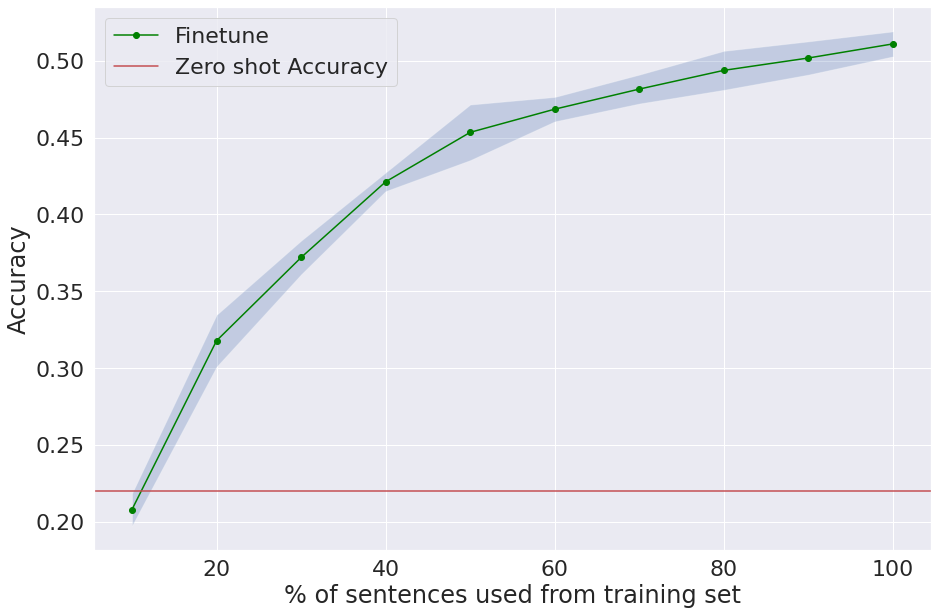

In [ ]:
perc = [i for i in range(10,110,10)]
ax = plt.plot(perc,mn,marker='o', color='green')
ax = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
rand1 = [mn[i]-std[i] for i in range(10)]
rand2 = [mn[i]+std[i] for i in range(10)]
ax =plt.fill_between(perc, rand1, rand2, alpha=0.25)
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.legend(['Finetune', 'Zero shot Accuracy'])

In [ ]:
res

,1,2,3,4,5,mean,std
0,0.203646,0.210559,0.217610,0.191824,0.215723,0.207872,0.010477
1,0.326210,0.293526,0.338365,0.310692,0.320126,0.317784,0.016873
2,0.357637,0.375864,0.383648,0.379245,0.363522,0.371983,0.010969
3,0.428033,0.413576,0.423899,0.416352,0.424528,0.421278,0.006055
4,0.465116,0.421747,0.464780,0.457233,0.458491,0.453473,0.018092
5,0.477058,0.458202,0.475472,0.463522,0.468553,0.468562,0.007948
6,0.471402,0.473287,0.494340,0.484277,0.484906,0.481642,0.009401
7,0.495286,0.477058,0.512579,0.491195,0.493082,0.493840,0.012673
8,0.503457,0.488372,0.517610,0.496226,0.503774,0.501888,0.010816
9,0.509114,0.501571,0.522013,0.506289,0.516352,0.511068,0.008132


In [ ]:
folds2 = finetune_validation(hidden_size=32)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.3660
13
epoch 50 / 50, step 13/13, loss = 0.4019
20
epoch 50 / 50, step 20/20, loss = 0.2077
26
epoch 50 / 50, step 26/26, loss = 0.3739
32
epoch 50 / 50, step 32/32, loss = 0.4090
39
epoch 50 / 50, step 39/39, loss = 0.2885
45
epoch 50 / 50, step 45/45, loss = 0.3965
51
epoch 50 / 50, step 51/51, loss = 0.3882
58
epoch 50 / 50, step 58/58, loss = 0.3913
64
epoch 50 / 50, step 64/64, loss = 0.4185
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.3865
13
epoch 50 / 50, step 13/13, loss = 0.4110
20
epoch 50 / 50, step 20/20, loss = 0.2178
26
epoch 50 / 50, step 26/26, loss = 0.3831
32
epoch 50 / 50, step 32/32, loss = 0.4037
39
epoch 50 / 50, step 39/39, loss = 0.2817
45
epoch 50 / 50, step 45/45, loss = 0.4013
51
epoch 50 / 50, step 51/51, loss = 0.3934
58
epoch 50 / 50, step 58/58, loss = 0.3529
64
epoch 50 / 50, step 64/64, loss = 0.4199
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.3879
13
epoch 50 / 50, step 13

In [ ]:
res2 = pd.DataFrame(folds2)
res2

,1,2,3,4,5
0,0.135764,0.149591,0.145283,0.138994,0.157862
1,0.228158,0.230044,0.253459,0.234591,0.238365
2,0.275927,0.253300,0.268553,0.269182,0.261635
3,0.330610,0.322439,0.339623,0.321384,0.331447
4,0.369579,0.337524,0.388679,0.344025,0.347170
5,0.380264,0.351980,0.372327,0.371069,0.362893
6,0.399120,0.373350,0.410063,0.376101,0.398113
7,0.426147,0.375236,0.420126,0.398742,0.419497
8,0.415462,0.390321,0.431447,0.408805,0.425157
9,0.429918,0.404777,0.436478,0.398113,0.437107


In [ ]:
mn2 = res2.mean(axis=1)
std2 = res2.std(axis=1)

In [ ]:
res2['mean'] = mn2
res2['std'] = std2
res2.to_csv('res32.csv',index=False)

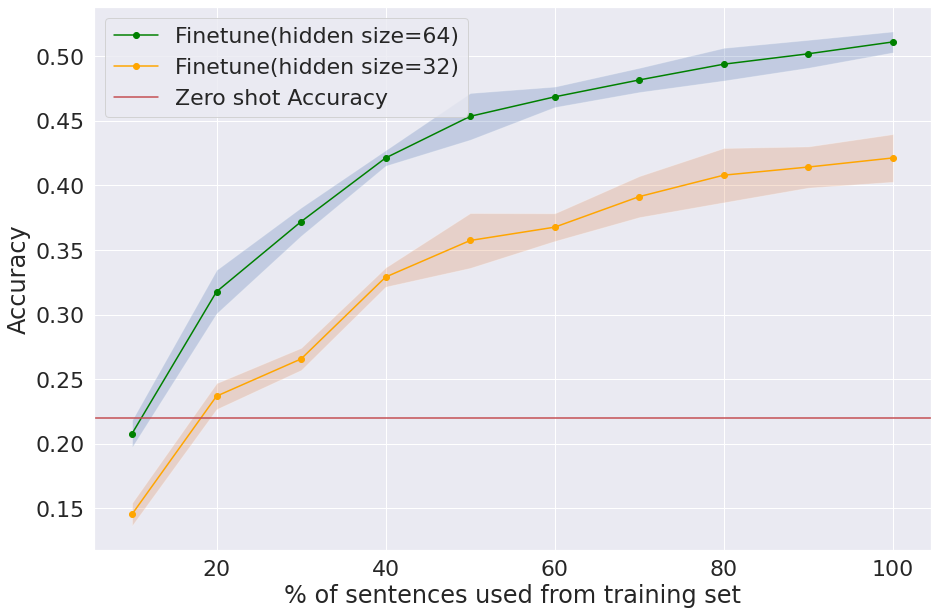

In [ ]:
ax = plt.plot(perc,mn,marker='o', color='green')
rand1 = [mn[i]-std[i] for i in range(10)]
rand2 = [mn[i]+std[i] for i in range(10)]
ax =plt.fill_between(perc, rand1, rand2, alpha=0.25)
ax = plt.plot(perc,mn2,marker='o', color='orange')
ran1 = [mn2[i]-std2[i] for i in range(10)]
ran2 = [mn2[i]+std2[i] for i in range(10)]
ax =plt.fill_between(perc, ran1, ran2, alpha=0.25)
ax = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.legend(['Finetune(hidden size=64)', 'Finetune(hidden size=32)','Zero shot Accuracy',])

In [ ]:
res2

,1,2,3,4,5,mean,std
0,0.135764,0.149591,0.145283,0.138994,0.157862,0.145499,0.008757
1,0.228158,0.230044,0.253459,0.234591,0.238365,0.236923,0.010064
2,0.275927,0.253300,0.268553,0.269182,0.261635,0.265720,0.008590
3,0.330610,0.322439,0.339623,0.321384,0.331447,0.329100,0.007457
4,0.369579,0.337524,0.388679,0.344025,0.347170,0.357395,0.021245
5,0.380264,0.351980,0.372327,0.371069,0.362893,0.367707,0.010734
6,0.399120,0.373350,0.410063,0.376101,0.398113,0.391349,0.015912
7,0.426147,0.375236,0.420126,0.398742,0.419497,0.407950,0.021022
8,0.415462,0.390321,0.431447,0.408805,0.425157,0.414238,0.015956
9,0.429918,0.404777,0.436478,0.398113,0.437107,0.421279,0.018474


In [ ]:
folds3 = finetune_validation(hidden_size=96)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1730
13
epoch 50 / 50, step 13/13, loss = 0.2912
20
epoch 50 / 50, step 20/20, loss = 0.0492
26
epoch 50 / 50, step 26/26, loss = 0.2751
32
epoch 50 / 50, step 32/32, loss = 0.3428
39
epoch 50 / 50, step 39/39, loss = 0.1537
45
epoch 50 / 50, step 45/45, loss = 0.3348
51
epoch 50 / 50, step 51/51, loss = 0.3423
58
epoch 50 / 50, step 58/58, loss = 0.2856
64
epoch 50 / 50, step 64/64, loss = 0.3617
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1847
13
epoch 50 / 50, step 13/13, loss = 0.3066
20
epoch 50 / 50, step 20/20, loss = 0.0491
26
epoch 50 / 50, step 26/26, loss = 0.2797
32
epoch 50 / 50, step 32/32, loss = 0.3373
39
epoch 50 / 50, step 39/39, loss = 0.1727
45
epoch 50 / 50, step 45/45, loss = 0.3335
51
epoch 50 / 50, step 51/51, loss = 0.3402
58
epoch 50 / 50, step 58/58, loss = 0.2716
64
epoch 50 / 50, step 64/64, loss = 0.3675
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1836
13
epoch 50 / 50, step 13

In [ ]:
res3 = pd.DataFrame(folds3)
res3

,1,2,3,4,5
0,0.224387,0.212445,0.238994,0.225157,0.230189
1,0.355123,0.335009,0.357233,0.340881,0.344654
2,0.385292,0.373350,0.399371,0.398113,0.399371
3,0.443746,0.441860,0.466038,0.442138,0.433962
4,0.462602,0.438089,0.483019,0.464151,0.472956
5,0.474544,0.470773,0.488050,0.479245,0.461635
6,0.492772,0.487115,0.500629,0.498742,0.505660
7,0.514771,0.498429,0.520755,0.508176,0.520126
8,0.513514,0.502200,0.522642,0.513836,0.520126
9,0.527970,0.520427,0.532075,0.534591,0.549057


In [ ]:
mn3 = res3.mean(axis=1)
std3 = res3.std(axis=1)

In [ ]:
res3['mean'] = mn3
res3['std'] = std3
res3.to_csv('res96.csv',index=False)

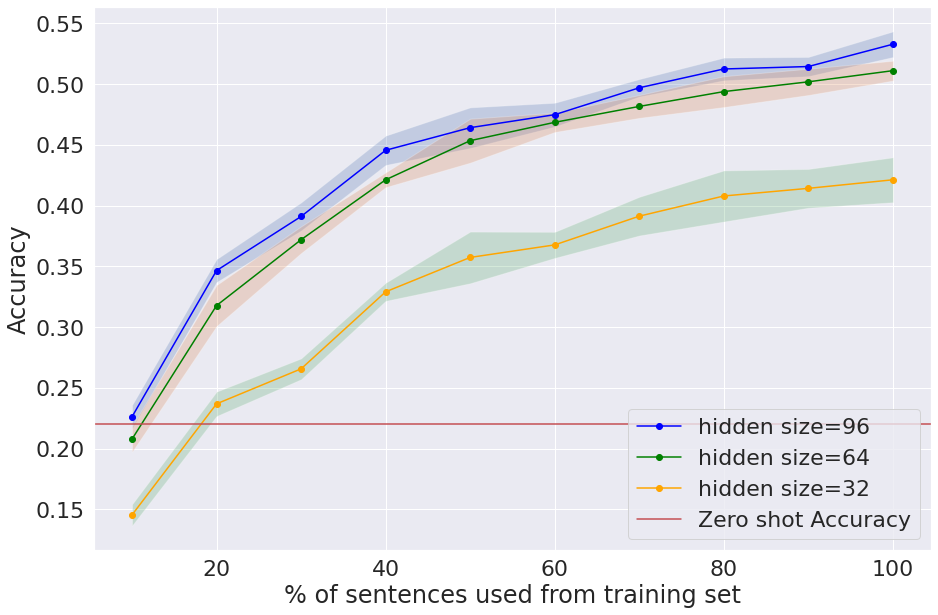

In [ ]:
ax = plt.plot(perc,mn3,marker='o', color='blue')
ra1 = [mn3[i]-std3[i] for i in range(10)]
ra2 = [mn3[i]+std3[i] for i in range(10)]
ax =plt.fill_between(perc, ra1, ra2, alpha=0.25)
ax = plt.plot(perc,mn,marker='o', color='green')
rand1 = [mn[i]-std[i] for i in range(10)]
rand2 = [mn[i]+std[i] for i in range(10)]
ax =plt.fill_between(perc, rand1, rand2, alpha=0.25)
ax = plt.plot(perc,mn2,marker='o', color='orange')
ran1 = [mn2[i]-std2[i] for i in range(10)]
ran2 = [mn2[i]+std2[i] for i in range(10)]
ax =plt.fill_between(perc, ran1, ran2, alpha=0.25)
ax = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.legend(['hidden size=96','hidden size=64', 'hidden size=32','Zero shot Accuracy'],loc=4)

In [ ]:
res3

,1,2,3,4,5,mean,std
0,0.224387,0.212445,0.238994,0.225157,0.230189,0.226234,0.009659
1,0.355123,0.335009,0.357233,0.340881,0.344654,0.346580,0.009441
2,0.385292,0.373350,0.399371,0.398113,0.399371,0.391100,0.011563
3,0.443746,0.441860,0.466038,0.442138,0.433962,0.445549,0.012068
4,0.462602,0.438089,0.483019,0.464151,0.472956,0.464163,0.016697
5,0.474544,0.470773,0.488050,0.479245,0.461635,0.474850,0.009810
6,0.492772,0.487115,0.500629,0.498742,0.505660,0.496984,0.007190
7,0.514771,0.498429,0.520755,0.508176,0.520126,0.512451,0.009329
8,0.513514,0.502200,0.522642,0.513836,0.520126,0.514463,0.007916
9,0.527970,0.520427,0.532075,0.534591,0.549057,0.532824,0.010541


In [ ]:
folds4 = finetune_validation(hidden_size=48)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.3040
13
epoch 50 / 50, step 13/13, loss = 0.3638
20
epoch 50 / 50, step 20/20, loss = 0.1251
26
epoch 50 / 50, step 26/26, loss = 0.3399
32
epoch 50 / 50, step 32/32, loss = 0.3864
39
epoch 50 / 50, step 39/39, loss = 0.2396
45
epoch 50 / 50, step 45/45, loss = 0.3803
51
epoch 50 / 50, step 51/51, loss = 0.3731
58
epoch 50 / 50, step 58/58, loss = 0.3613
64
epoch 50 / 50, step 64/64, loss = 0.3958
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.3173
13
epoch 50 / 50, step 13/13, loss = 0.3783
20
epoch 50 / 50, step 20/20, loss = 0.1326
26
epoch 50 / 50, step 26/26, loss = 0.3454
32
epoch 50 / 50, step 32/32, loss = 0.3759
39
epoch 50 / 50, step 39/39, loss = 0.2436
45
epoch 50 / 50, step 45/45, loss = 0.3782
51
epoch 50 / 50, step 51/51, loss = 0.3766
58
epoch 50 / 50, step 58/58, loss = 0.3152
64
epoch 50 / 50, step 64/64, loss = 0.4017
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.3003
13
epoch 50 / 50, step 13

In [ ]:
res4 = pd.DataFrame(folds4)
res4

,1,2,3,4,5
0,0.192332,0.172847,0.206289,0.169182,0.191824
1,0.293526,0.275299,0.320126,0.278616,0.299371
2,0.340038,0.330610,0.361006,0.349057,0.340881
3,0.394720,0.377750,0.408805,0.402516,0.406289
4,0.425519,0.408548,0.447799,0.430189,0.422013
5,0.440603,0.409805,0.448428,0.428302,0.424528
6,0.454431,0.439346,0.461006,0.471069,0.450943
7,0.460088,0.446260,0.492453,0.458491,0.475472
8,0.483344,0.454431,0.487421,0.462893,0.481761
9,0.491515,0.463859,0.494340,0.469811,0.486792


In [ ]:
mn4= res4.mean(axis=1)
std4 = res4.std(axis=1)

In [ ]:
res4['mean'] = mn4
res4['std'] = std4
res4.to_csv('res48.csv',index=False)

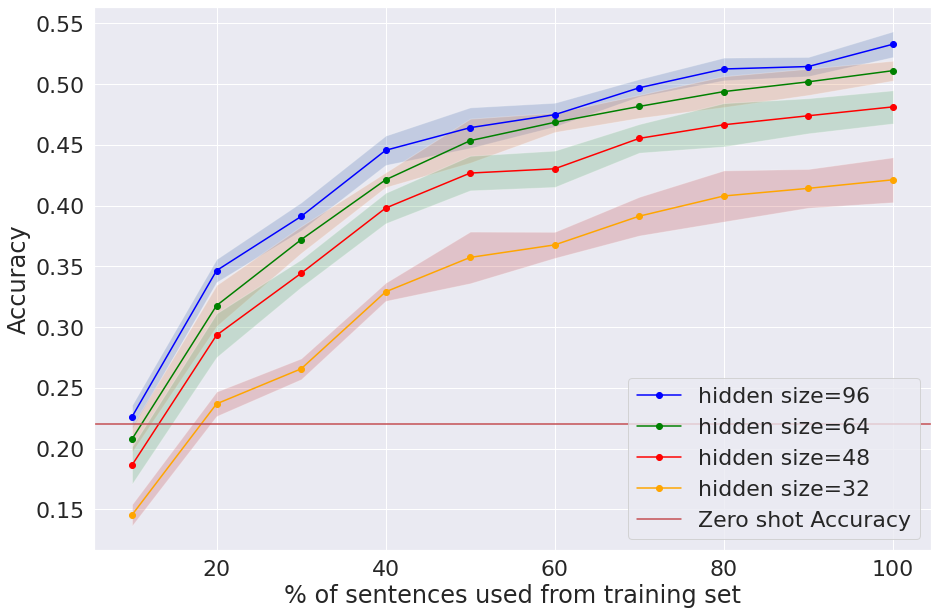

In [ ]:
ax = plt.plot(perc,mn3,marker='o', color='blue')
ra1 = [mn3[i]-std3[i] for i in range(10)]
ra2 = [mn3[i]+std3[i] for i in range(10)]
ax =plt.fill_between(perc, ra1, ra2, alpha=0.25)
ax = plt.plot(perc,mn,marker='o', color='green')
rand1 = [mn[i]-std[i] for i in range(10)]
rand2 = [mn[i]+std[i] for i in range(10)]
ax =plt.fill_between(perc, rand1, rand2, alpha=0.25)
ax = plt.plot(perc,mn4,marker='o', color='red')
r1 = [mn4[i]-std4[i] for i in range(10)]
r2 = [mn4[i]+std4[i] for i in range(10)]
ax =plt.fill_between(perc, r1, r2, alpha=0.25)
ax = plt.plot(perc,mn2,marker='o', color='orange')
ran1 = [mn2[i]-std2[i] for i in range(10)]
ran2 = [mn2[i]+std2[i] for i in range(10)]
ax =plt.fill_between(perc, ran1, ran2, alpha=0.25)
ax = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.legend(['hidden size=96','hidden size=64','hidden size=48', 'hidden size=32','Zero shot Accuracy'],loc=4)

In [ ]:
res4

,1,2,3,4,5,mean,std
0,0.192332,0.172847,0.206289,0.169182,0.191824,0.186495,0.015332
1,0.293526,0.275299,0.320126,0.278616,0.299371,0.293388,0.018001
2,0.340038,0.330610,0.361006,0.349057,0.340881,0.344318,0.011391
3,0.394720,0.377750,0.408805,0.402516,0.406289,0.398016,0.012517
4,0.425519,0.408548,0.447799,0.430189,0.422013,0.426813,0.014231
5,0.440603,0.409805,0.448428,0.428302,0.424528,0.430333,0.014934
6,0.454431,0.439346,0.461006,0.471069,0.450943,0.455359,0.011784
7,0.460088,0.446260,0.492453,0.458491,0.475472,0.466553,0.017811
8,0.483344,0.454431,0.487421,0.462893,0.481761,0.473970,0.014439
9,0.491515,0.463859,0.494340,0.469811,0.486792,0.481263,0.013608


In [ ]:
768*96*2

147456

In [ ]:
((768*768)/2)/768

384.0

In [ ]:
768*256*2

393216

In [ ]:
folds5 = finetune_validation(hidden_size=256)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.0644
13
epoch 50 / 50, step 13/13, loss = 0.1635
20
epoch 50 / 50, step 20/20, loss = 0.0284
26
epoch 50 / 50, step 26/26, loss = 0.1491
32
epoch 50 / 50, step 32/32, loss = 0.2528
39
epoch 50 / 50, step 39/39, loss = 0.0541
45
epoch 50 / 50, step 45/45, loss = 0.2185
51
epoch 50 / 50, step 51/51, loss = 0.2759
58
epoch 50 / 50, step 58/58, loss = 0.1309
64
epoch 50 / 50, step 64/64, loss = 0.2645
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.0605
13
epoch 50 / 50, step 13/13, loss = 0.1615
20
epoch 50 / 50, step 20/20, loss = 0.0272
26
epoch 50 / 50, step 26/26, loss = 0.1482
32
epoch 50 / 50, step 32/32, loss = 0.2410
39
epoch 50 / 50, step 39/39, loss = 0.0619
45
epoch 50 / 50, step 45/45, loss = 0.2213
51
epoch 50 / 50, step 51/51, loss = 0.2758
58
epoch 50 / 50, step 58/58, loss = 0.1309
64
epoch 50 / 50, step 64/64, loss = 0.2685
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.0631
13
epoch 50 / 50, step 13

In [ ]:
res5 = pd.DataFrame(folds5)
res5

,1,2,3,4,5
0,0.200503,0.191703,0.218239,0.185535,0.211950
1,0.247643,0.238843,0.267925,0.259119,0.259748
2,0.297297,0.277184,0.322013,0.294340,0.306918
3,0.343809,0.326210,0.355975,0.330818,0.335220
4,0.372093,0.359522,0.395597,0.377358,0.395597
5,0.402891,0.382150,0.408805,0.406289,0.400629
6,0.424261,0.415462,0.430818,0.440881,0.439623
7,0.429918,0.441232,0.445912,0.440881,0.464151
8,0.446260,0.439346,0.456604,0.462264,0.471698
9,0.466373,0.455060,0.481132,0.455346,0.491824


In [ ]:
mn5= res5.mean(axis=1)
std5 = res5.std(axis=1)

In [ ]:
res5['mean'] = mn5
res5['std'] = std5
res5.to_csv('res256.csv',index=False)

In [ ]:
res5

,1,2,3,4,5,mean,std
0,0.200503,0.191703,0.218239,0.185535,0.211950,0.201586,0.013613
1,0.247643,0.238843,0.267925,0.259119,0.259748,0.254656,0.011414
2,0.297297,0.277184,0.322013,0.294340,0.306918,0.299550,0.016518
3,0.343809,0.326210,0.355975,0.330818,0.335220,0.338406,0.011772
4,0.372093,0.359522,0.395597,0.377358,0.395597,0.380034,0.015616
5,0.402891,0.382150,0.408805,0.406289,0.400629,0.400153,0.010540
6,0.424261,0.415462,0.430818,0.440881,0.439623,0.430209,0.010674
7,0.429918,0.441232,0.445912,0.440881,0.464151,0.444419,0.012495
8,0.446260,0.439346,0.456604,0.462264,0.471698,0.455235,0.012800
9,0.466373,0.455060,0.481132,0.455346,0.491824,0.469947,0.016212


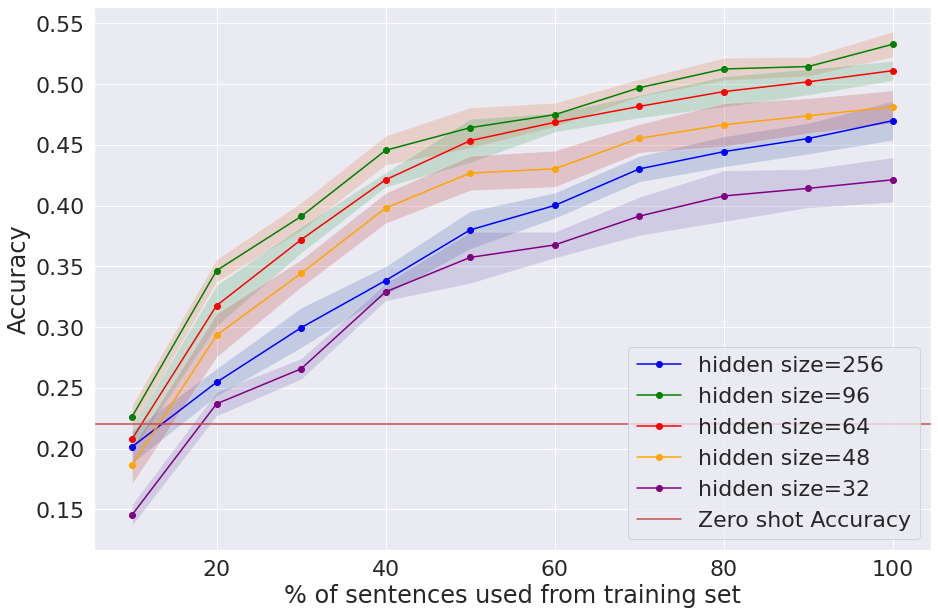

In [ ]:
colors = ['blue', 'green', 'red', 'orange', 'purple']
perc = [i for i in range(10,110,10)]
files = ['res256.csv','res96.csv','res64.csv','res48.csv','res32.csv']

for i in range(5):
  res = pd.read_csv(files[i])
  ax = plt.plot(perc,res['mean'],marker='o', color=colors[i])
  ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  ax =plt.fill_between(perc, ra1, ra2, alpha=0.25)

ax = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.legend(['hidden size=256','hidden size=96','hidden size=64','hidden size=48', 'hidden size=32','Zero shot Accuracy'],loc=4)

In [ ]:
folds6 = finetune_validation(hidden_size=128)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1401
13
epoch 50 / 50, step 13/13, loss = 0.2556
20
epoch 50 / 50, step 20/20, loss = 0.0338
26
epoch 50 / 50, step 26/26, loss = 0.2396
32
epoch 50 / 50, step 32/32, loss = 0.3194
39
epoch 50 / 50, step 39/39, loss = 0.1132
45
epoch 50 / 50, step 45/45, loss = 0.3124
51
epoch 50 / 50, step 51/51, loss = 0.3283
58
epoch 50 / 50, step 58/58, loss = 0.2500
64
epoch 50 / 50, step 64/64, loss = 0.3376
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1447
13
epoch 50 / 50, step 13/13, loss = 0.2720
20
epoch 50 / 50, step 20/20, loss = 0.0347
26
epoch 50 / 50, step 26/26, loss = 0.2514
32
epoch 50 / 50, step 32/32, loss = 0.3075
39
epoch 50 / 50, step 39/39, loss = 0.1341
45
epoch 50 / 50, step 45/45, loss = 0.3078
51
epoch 50 / 50, step 51/51, loss = 0.3247
58
epoch 50 / 50, step 58/58, loss = 0.2300
64
epoch 50 / 50, step 64/64, loss = 0.3418
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1459
13
epoch 50 / 50, step 13

In [ ]:
res6 = pd.DataFrame(folds6[0])
res6

,1,2,3,4,5
0,0.239472,0.201760,0.248428,0.223270,0.230189
1,0.337524,0.313639,0.342767,0.329560,0.362264
2,0.388435,0.376493,0.402516,0.386164,0.400629
3,0.424261,0.416719,0.427673,0.429560,0.452201
4,0.467002,0.436204,0.484277,0.459119,0.475472
5,0.478944,0.465116,0.488679,0.448428,0.472327
6,0.498429,0.464488,0.506918,0.503145,0.494340
7,0.512885,0.481458,0.494340,0.505031,0.515723
8,0.510371,0.502828,0.539623,0.513208,0.518868
9,0.521056,0.513514,0.538994,0.535849,0.538365


In [ ]:
mn6= res6.mean(axis=1)
std6 = res6.std(axis=1)

In [ ]:
res6['mean'] = mn6
res6['std'] = std6
res6.to_csv('res128.csv',index=False)

In [ ]:
res6

,1,2,3,4,5,mean,std
0,0.239472,0.201760,0.248428,0.223270,0.230189,0.228624,0.017767
1,0.337524,0.313639,0.342767,0.329560,0.362264,0.337151,0.017838
2,0.388435,0.376493,0.402516,0.386164,0.400629,0.390847,0.010789
3,0.424261,0.416719,0.427673,0.429560,0.452201,0.430083,0.013302
4,0.467002,0.436204,0.484277,0.459119,0.475472,0.464415,0.018353
5,0.478944,0.465116,0.488679,0.448428,0.472327,0.470699,0.015175
6,0.498429,0.464488,0.506918,0.503145,0.494340,0.493464,0.016880
7,0.512885,0.481458,0.494340,0.505031,0.515723,0.501888,0.014112
8,0.510371,0.502828,0.539623,0.513208,0.518868,0.516979,0.013914
9,0.521056,0.513514,0.538994,0.535849,0.538365,0.529555,0.011575


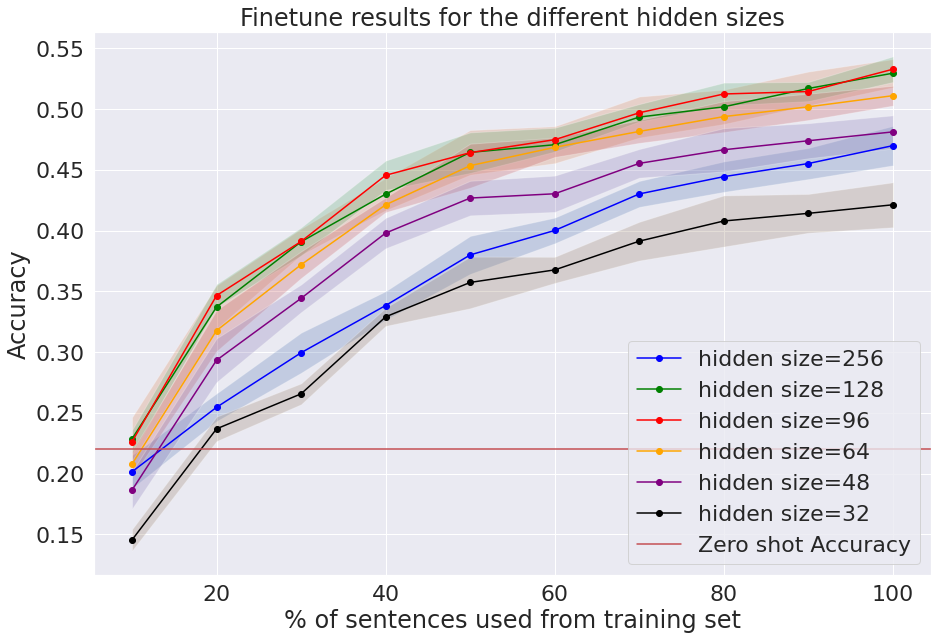

In [ ]:
colors = ['blue', 'green', 'red', 'orange', 'purple','black']
perc = [i for i in range(10,110,10)]
files = ['res256.csv','res128.csv','res96.csv','res64.csv','res48.csv','res32.csv']

for i in range(6):
  res = pd.read_csv(files[i])
  ax = plt.plot(perc,res['mean'],marker='o', color=colors[i])
  ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  ax =plt.fill_between(perc, ra1, ra2, alpha=0.25)

ax = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.title('Finetune results for the different hidden sizes')
plt.legend(['hidden size=256','hidden size=128','hidden size=96','hidden size=64','hidden size=48', 'hidden size=32','Zero shot Accuracy'],loc=4)

In [ ]:
folds = finetune_validation()

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.2519
13
epoch 50 / 50, step 13/13, loss = 0.3325
20
epoch 50 / 50, step 20/20, loss = 0.0980
26
epoch 50 / 50, step 26/26, loss = 0.3209
32
epoch 50 / 50, step 32/32, loss = 0.3676
39
epoch 50 / 50, step 39/39, loss = 0.2108
45
epoch 50 / 50, step 45/45, loss = 0.3613
51
epoch 50 / 50, step 51/51, loss = 0.3599
58
epoch 50 / 50, step 58/58, loss = 0.3275
64
epoch 50 / 50, step 64/64, loss = 0.3801
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.2515
13
epoch 50 / 50, step 13/13, loss = 0.3466
20
epoch 50 / 50, step 20/20, loss = 0.0837
26
epoch 50 / 50, step 26/26, loss = 0.3261
32
epoch 50 / 50, step 32/32, loss = 0.3613
39
epoch 50 / 50, step 39/39, loss = 0.2193
45
epoch 50 / 50, step 45/45, loss = 0.3619
51
epoch 50 / 50, step 51/51, loss = 0.3606
58
epoch 50 / 50, step 58/58, loss = 0.3041
64
epoch 50 / 50, step 64/64, loss = 0.3834
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.2549
13
epoch 50 / 50, step 13

In [ ]:
count = 0
for i in folds:
  count +=1
  res = pd.DataFrame(i)
  
  res['mean'] = res.mean(axis=1)
  res['std'] = res.std(axis=1)

  res.to_csv('res'+str(count)+'.csv',index=False)

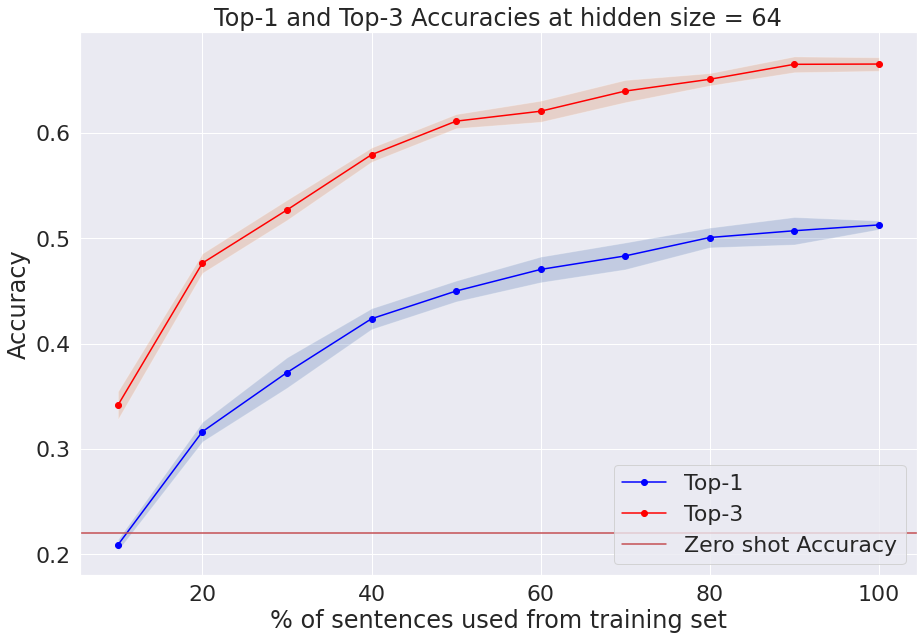

In [ ]:
colors = ['blue','red']
perc = [i for i in range(10,110,10)]
files = ['res1.csv','res2.csv']

for i in range(2):
  res = pd.read_csv(files[i])
  ax1 = plt.plot(perc,res['mean'],marker='o', color=colors[i])
  ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  ax1 =plt.fill_between(perc, ra1, ra2, alpha=0.25)

ax1 = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.title('Top-1 and Top-3 Accuracies at hidden size = 64')
plt.legend(['Top-1','Top-3','Zero shot Accuracy'],loc=4)

In [ ]:
folds2 = finetune_validation(hidden_size=96)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1785
13
epoch 50 / 50, step 13/13, loss = 0.2906
20
epoch 50 / 50, step 20/20, loss = 0.0546
26
epoch 50 / 50, step 26/26, loss = 0.2819
32
epoch 50 / 50, step 32/32, loss = 0.3454
39
epoch 50 / 50, step 39/39, loss = 0.1591
45
epoch 50 / 50, step 45/45, loss = 0.3391
51
epoch 50 / 50, step 51/51, loss = 0.3420
58
epoch 50 / 50, step 58/58, loss = 0.2885
64
epoch 50 / 50, step 64/64, loss = 0.3612
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1786
13
epoch 50 / 50, step 13/13, loss = 0.2984
20
epoch 50 / 50, step 20/20, loss = 0.0494
26
epoch 50 / 50, step 26/26, loss = 0.2825
32
epoch 50 / 50, step 32/32, loss = 0.3374
39
epoch 50 / 50, step 39/39, loss = 0.1650
45
epoch 50 / 50, step 45/45, loss = 0.3319
51
epoch 50 / 50, step 51/51, loss = 0.3392
58
epoch 50 / 50, step 58/58, loss = 0.2608
64
epoch 50 / 50, step 64/64, loss = 0.3608
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1836
13
epoch 50 / 50, step 13

In [ ]:
count = 0
for i in folds2:
  count +=1
  res = pd.DataFrame(i)
  
  res['mean'] = res.mean(axis=1)
  res['std'] = res.std(axis=1)

  res.to_csv('res2'+str(count)+'.csv',index=False)

          1         2         3         4         5      mean       std
0  0.240729  0.213074  0.244654  0.207547  0.220126  0.225226  0.014860
1  0.340038  0.315525  0.355975  0.338994  0.359748  0.342056  0.015647
2  0.394092  0.377750  0.394969  0.392453  0.400629  0.391978  0.007628
3  0.433061  0.432432  0.445912  0.415723  0.444025  0.434231  0.010766
4  0.477058  0.451917  0.486164  0.459119  0.467296  0.468311  0.012243
5  0.490886  0.470773  0.493082  0.477987  0.478616  0.482269  0.008426
6  0.504714  0.484601  0.503774  0.514465  0.504403  0.502391  0.009733
7  0.504714  0.490258  0.525157  0.509434  0.527044  0.511321  0.013635
8  0.517913  0.493400  0.526415  0.511321  0.532075  0.516225  0.013438
9  0.524827  0.519170  0.542767  0.538994  0.537107  0.532573  0.009004
          1         2         3         4         5      mean       std
0  0.366436  0.350094  0.384277  0.338994  0.352830  0.358526  0.015561
1  0.493400  0.472030  0.503774  0.484277  0.511321  0.492960  0

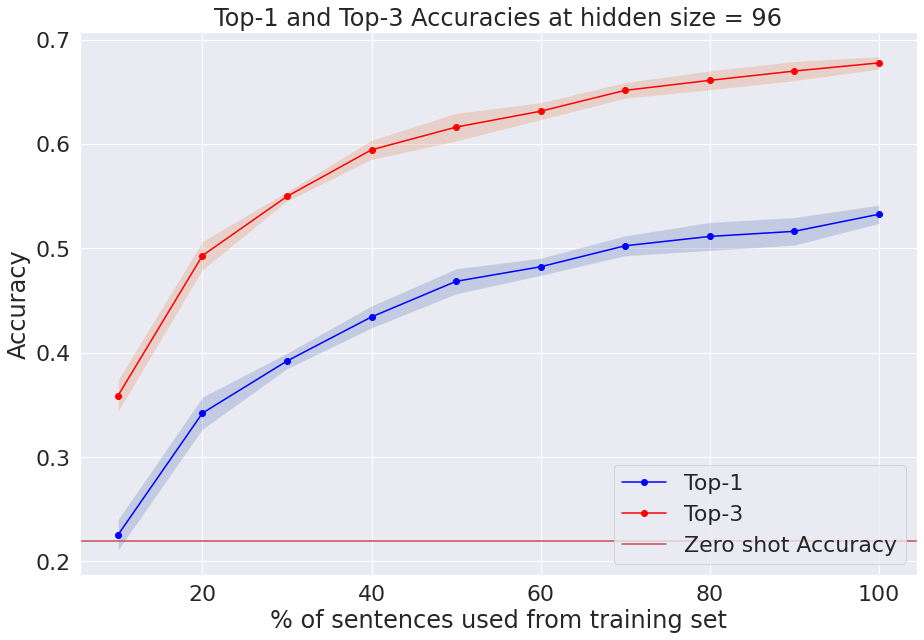

In [ ]:
colors = ['blue','red']
perc = [i for i in range(10,110,10)]
files = ['res21.csv','res22.csv']

for i in range(2):
  res = pd.read_csv(files[i])
  print(res)
  ax2 = plt.plot(perc,res['mean'],marker='o', color=colors[i])
  ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  ax2 =plt.fill_between(perc, ra1, ra2, alpha=0.25)

ax2 = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.title('Top-1 and Top-3 Accuracies at hidden size = 96')
plt.legend(['Top-1','Top-3','Zero shot Accuracy'],loc=4)

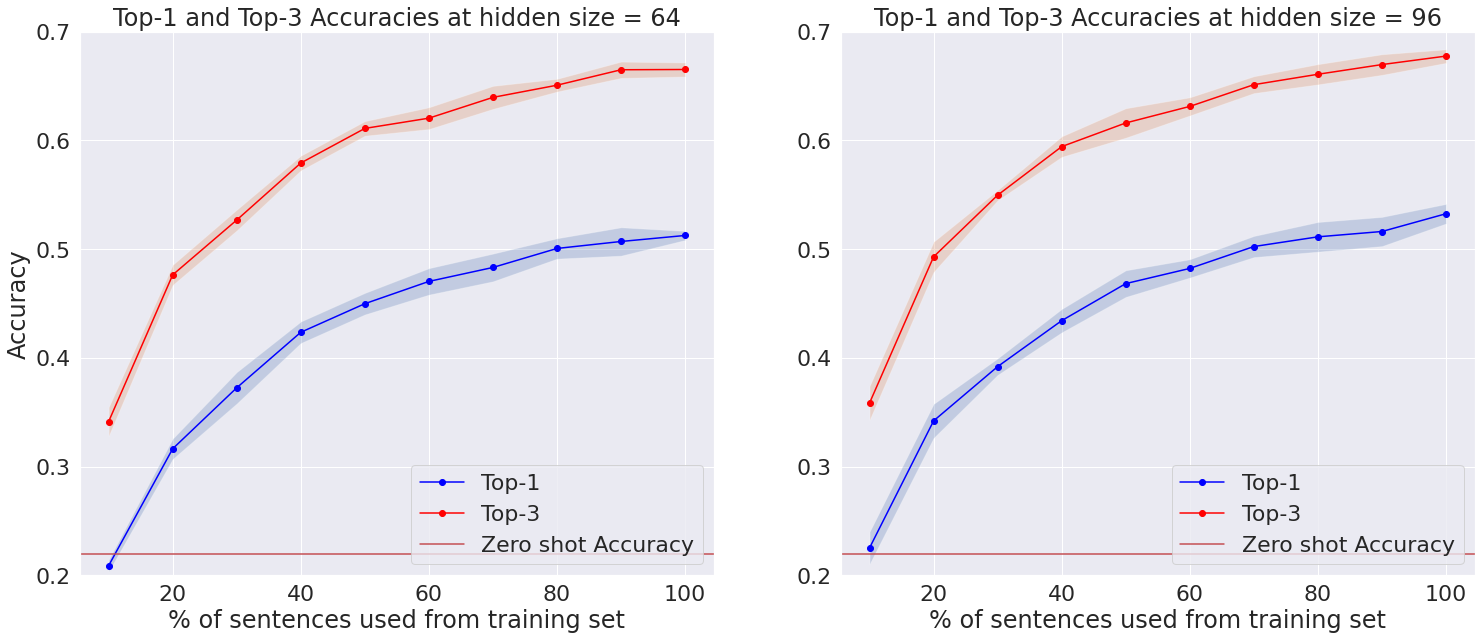

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (25,10))

colors = ['blue','red']
files = ['res1.csv','res2.csv']
files2 = ['res21.csv','res22.csv']

for i in range(2):
  res = pd.read_csv(files[i])
  ax1.plot(perc,res['mean'],marker='o', color=colors[i])
  ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  ax1.fill_between(perc, ra1, ra2, alpha=0.25)

  res2 = pd.read_csv(files2[i])
  ax2.plot(perc,res2['mean'],marker='o', color=colors[i])
  r1 = [res2['mean'][j]-res2['std'][j] for j in range(10)]
  r2 = [res2['mean'][j]+res2['std'][j] for j in range(10)]
  ax2.fill_between(perc, r1, r2, alpha=0.25)

ax1.axhline(y = 0.219945, color = 'r', linestyle = '-')
ax1.set_ylim([0.2, 0.7])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('% of sentences used from training set')
ax1.set_title('Top-1 and Top-3 Accuracies at hidden size = 64')
ax1.legend(['Top-1','Top-3','Zero shot Accuracy'],loc=4)

ax2.axhline(y = 0.219945, color = 'r', linestyle = '-')
ax2.set_ylim([0.2, 0.7])
ax2.set_label('Accuracy')
ax2.set_xlabel('% of sentences used from training set')
ax2.set_title('Top-1 and Top-3 Accuracies at hidden size = 96')
ax2.legend(['Top-1','Top-3','Zero shot Accuracy'],loc=4)

In [ ]:
folds2 = finetune_validation(hidden_size=96)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1804
13
epoch 50 / 50, step 13/13, loss = 0.2903
20
epoch 50 / 50, step 20/20, loss = 0.0539
26
epoch 50 / 50, step 26/26, loss = 0.2763
32
epoch 50 / 50, step 32/32, loss = 0.3395
39
epoch 50 / 50, step 39/39, loss = 0.1708
45
epoch 50 / 50, step 45/45, loss = 0.3337
51
epoch 50 / 50, step 51/51, loss = 0.3422
58
epoch 50 / 50, step 58/58, loss = 0.2921
64
epoch 50 / 50, step 64/64, loss = 0.3639
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1822
13
epoch 50 / 50, step 13/13, loss = 0.3020
20
epoch 50 / 50, step 20/20, loss = 0.0492
26
epoch 50 / 50, step 26/26, loss = 0.2839
32
epoch 50 / 50, step 32/32, loss = 0.3356
39
epoch 50 / 50, step 39/39, loss = 0.1661
45
epoch 50 / 50, step 45/45, loss = 0.3354
51
epoch 50 / 50, step 51/51, loss = 0.3424
58
epoch 50 / 50, step 58/58, loss = 0.2669
64
epoch 50 / 50, step 64/64, loss = 0.3599
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1924
13
epoch 50 / 50, step 13

In [ ]:
count = 0
for i in folds2[:2]:
  count +=1
  res = pd.DataFrame(i)
  
  res['mean'] = res.mean(axis=1)
  res['std'] = res.std(axis=1)

  res.to_csv('thres2'+str(count)+'.csv',index=False)

          1         2         3         4         5      mean       std
0  0.222502  0.204903  0.255975  0.208805  0.230818  0.224600  0.018248
1  0.331867  0.313011  0.354088  0.347170  0.335849  0.336397  0.014119
2  0.399120  0.372093  0.413208  0.386792  0.392453  0.392733  0.013575
3  0.434318  0.432432  0.438365  0.432704  0.447799  0.437124  0.005743
4  0.469516  0.447517  0.476730  0.457233  0.466667  0.463532  0.010158
5  0.472030  0.464488  0.498113  0.479874  0.471069  0.477115  0.011579
6  0.494029  0.483344  0.510692  0.500000  0.505031  0.498619  0.009415
7  0.497800  0.512885  0.508805  0.518868  0.513208  0.510313  0.007029
8  0.517285  0.500314  0.525786  0.522013  0.537107  0.520501  0.012032
9  0.515399  0.520427  0.535849  0.527673  0.523270  0.524524  0.006925
          1         2         3         4         5      mean       std
0  0.363922  0.350723  0.391195  0.345283  0.361006  0.362426  0.015892
1  0.495286  0.461974  0.509434  0.488679  0.481132  0.487301  0

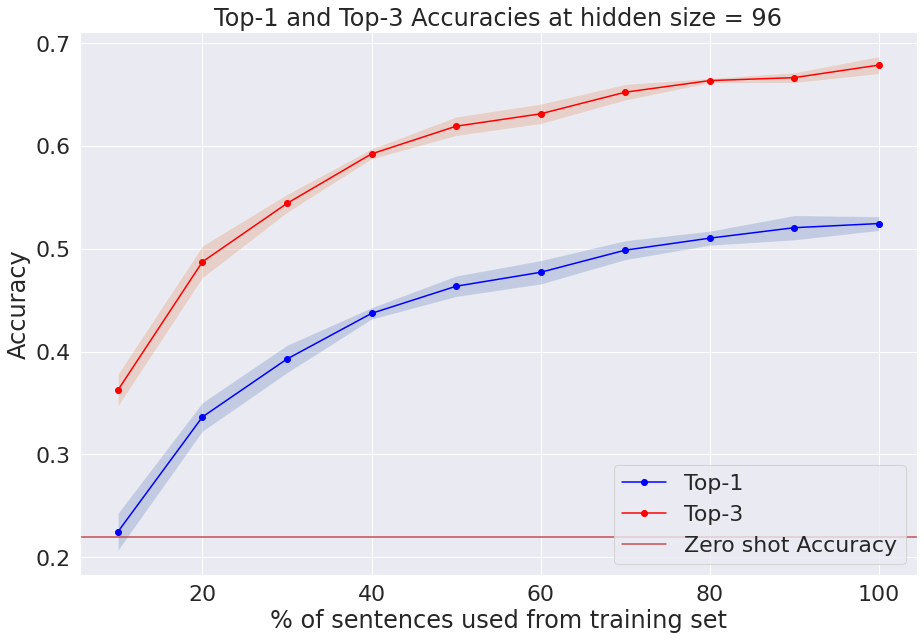

In [ ]:
colors = ['blue','red']
perc = [i for i in range(10,110,10)]
files = ['thres21.csv','thres22.csv']

for i in range(2):
  res = pd.read_csv(files[i])
  print(res)
  ax2 = plt.plot(perc,res['mean'],marker='o', color=colors[i])
  ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  ax2 =plt.fill_between(perc, ra1, ra2, alpha=0.25)

ax2 = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.title('Top-1 and Top-3 Accuracies at hidden size = 96')
plt.legend(['Top-1','Top-3','Zero shot Accuracy'],loc=4)

5
7
9


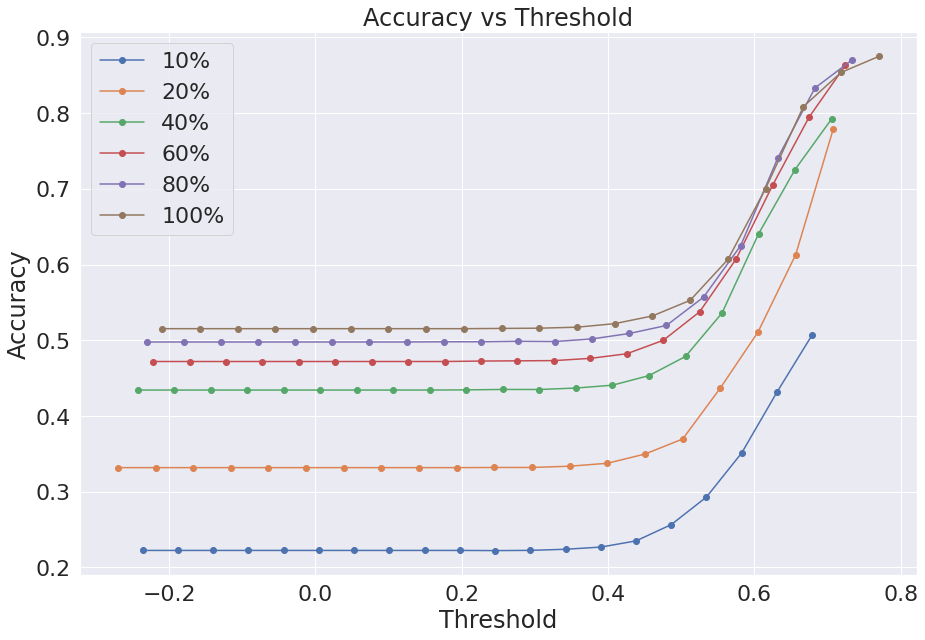

In [ ]:
rs = [0,1,3,5,7,9]
for i in rs:
  ax2 = plt.plot(folds2[2]['1'][i],folds2[3]['1'][i],marker='o')
  if folds2[3]['1'][i][-1]>=0.8:
    print(i)

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Threshold')
plt.legend([str(i)+'%' for i in [10,20,40,60,80,100]],loc=2)

2
4
5
6
7
8
9


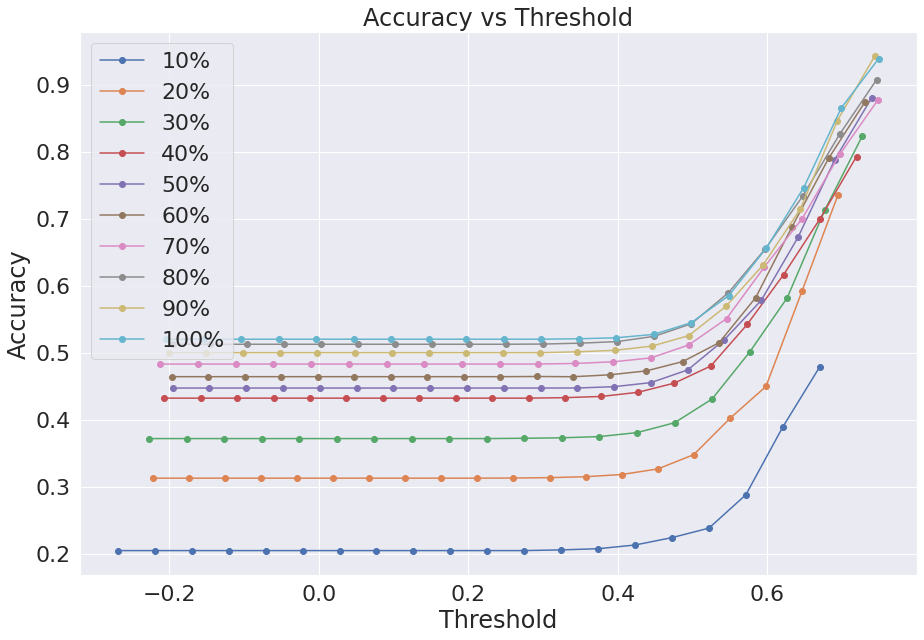

In [ ]:
#@title
for i in range(10):
  ax2 = plt.plot(folds2[2]['2'][i],folds2[3]['2'][i],marker='o')
  if folds2[3]['2'][i][-1]>=0.8:
    print(i)

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Threshold')
plt.legend([str(i)+'%' for i in range(10,110,10)],loc=2)

2
3
4
5
6
7
8
9


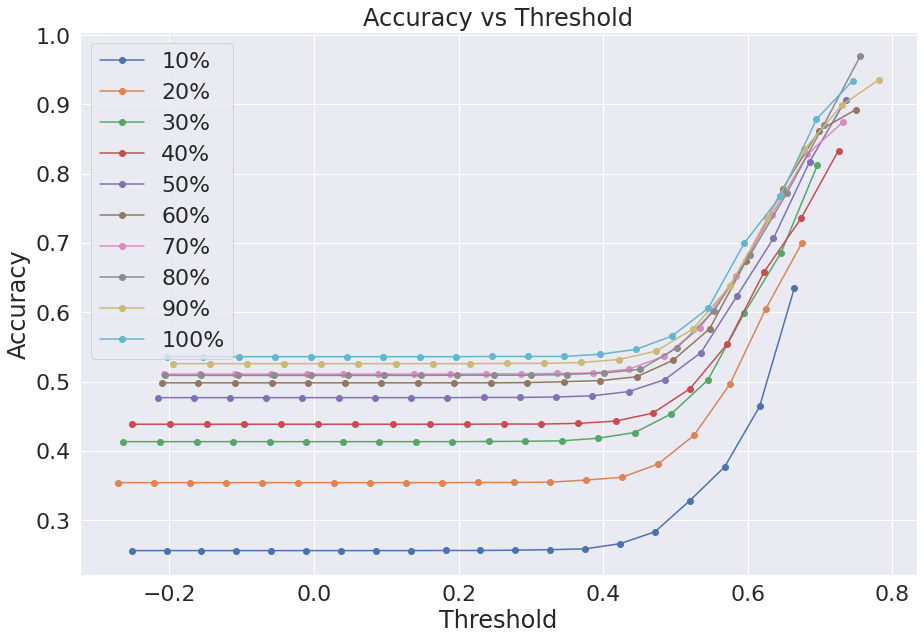

In [ ]:
#@title
for i in range(10):
  ax2 = plt.plot(folds2[2]['3'][i],folds2[3]['3'][i],marker='o')
  if folds2[3]['3'][i][-1]>=0.8:
    print(i)

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Threshold')
plt.legend([str(i)+'%' for i in range(10,110,10)],loc=2)

1
2
3
4
5
6
7
8
9


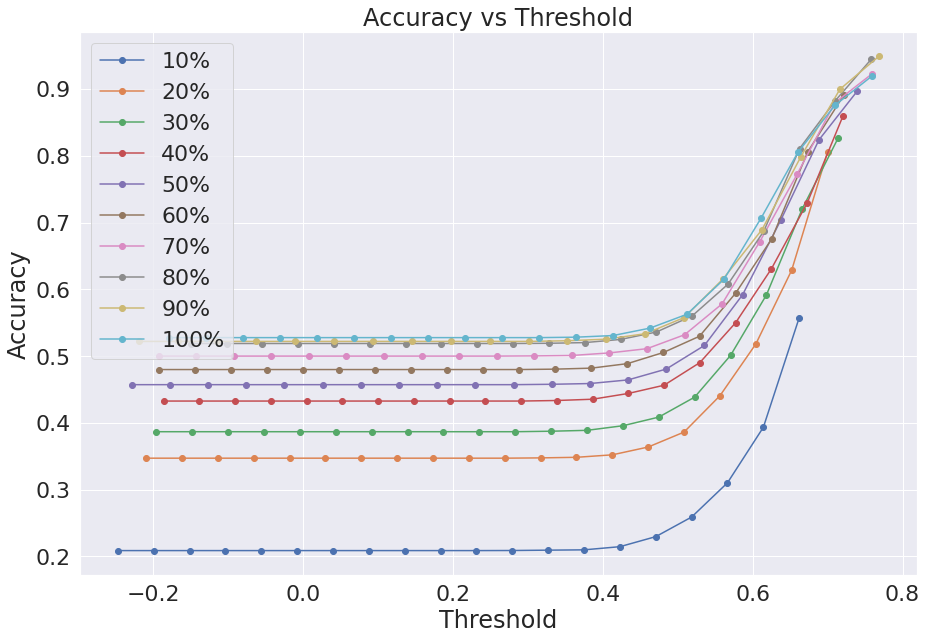

In [ ]:
#@title
for i in range(10):
  ax2 = plt.plot(folds2[2]['4'][i],folds2[3]['4'][i],marker='o')
  if folds2[3]['4'][i][-1]>=0.8:
    print(i)

  # ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  # ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  # ax2 =plt.fill_between(perc, ra1, ra2, alpha=0.25)

# ax2 = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Threshold')
plt.legend([str(i)+'%' for i in range(10,110,10)],loc=2)

2
3
4
5
6
7
8
9


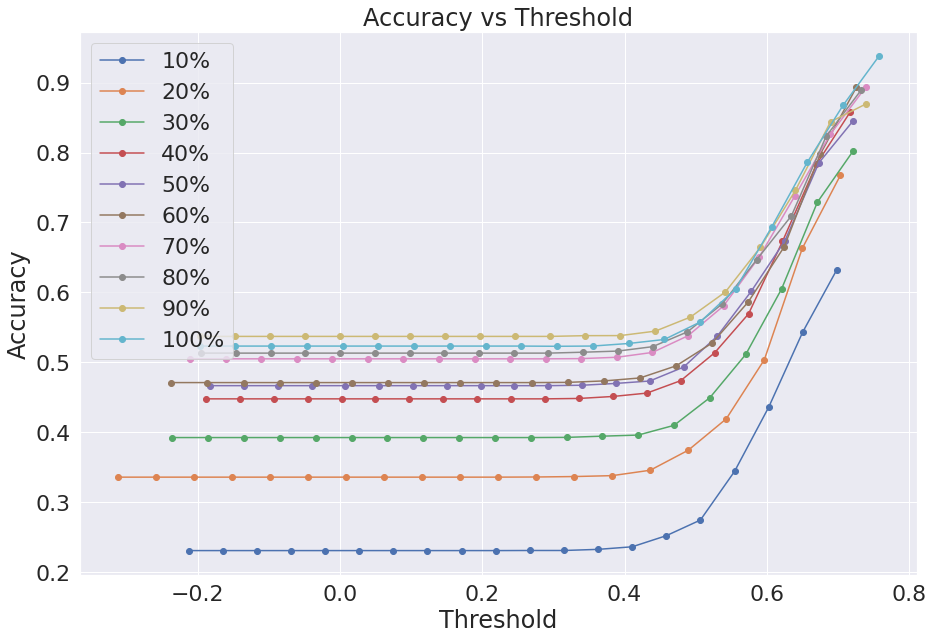

In [ ]:
#@title
for i in range(10):
  ax2 = plt.plot(folds2[2]['5'][i],folds2[3]['5'][i],marker='o')
  if folds2[3]['5'][i][-1]>=0.8:
    print(i)

  # ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  # ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  # ax2 =plt.fill_between(perc, ra1, ra2, alpha=0.25)

# ax2 = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Threshold')
plt.legend([str(i)+'%' for i in range(10,110,10)],loc=2)

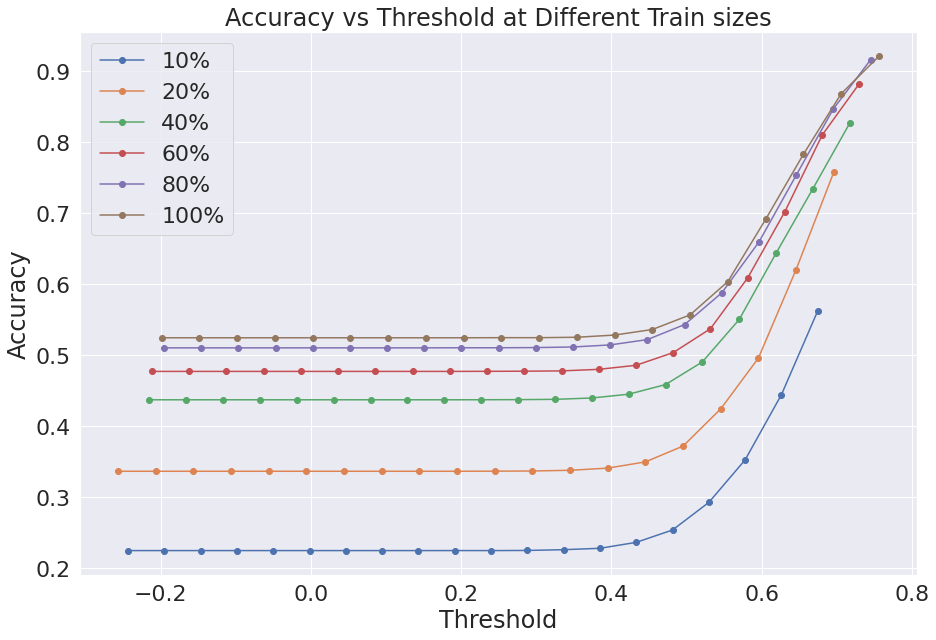

In [ ]:
avg_t = [pd.DataFrame([folds2[2][str(i)][j] for i in range(1,6)]).mean(axis=0) for j in range(10)]

avg_a = [pd.DataFrame([folds2[3][str(i)][j] for i in range(1,6)]).mean(axis=0) for j in range(10)]
std_a = [pd.DataFrame([folds2[3][str(i)][j] for i in range(1,6)]).std(axis=0) for j in range(10)]

rs = [0,1,3,5,7,9]
for i in rs:
  ax2 = plt.plot(avg_t[i],avg_a[i],marker='o')

  ra1 = [avg_a[i][j]-std_a[i][j] for j in range(10)]
  ra2 = [avg_a[i][j]+std_a[i][j] for j in range(10)]
  #ax2 =plt.fill_between(avg_t[i], ra1, ra2, alpha=0.25)

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Threshold at Different Train sizes')
plt.legend([str(i)+'%' for i in [10,20,40,60,80,100]],loc=2)

In [ ]:
files = ['thres21.csv','thres22.csv']

for i in files:
  df = pd.read_csv(i)
  print(df.head())
  print(df.shape)

          1         2         3         4         5      mean       std
0  0.222502  0.204903  0.255975  0.208805  0.230818  0.224600  0.018248
1  0.331867  0.313011  0.354088  0.347170  0.335849  0.336397  0.014119
2  0.399120  0.372093  0.413208  0.386792  0.392453  0.392733  0.013575
3  0.434318  0.432432  0.438365  0.432704  0.447799  0.437124  0.005743
4  0.469516  0.447517  0.476730  0.457233  0.466667  0.463532  0.010158
(10, 7)
          1         2         3         4         5      mean       std
0  0.363922  0.350723  0.391195  0.345283  0.361006  0.362426  0.015892
1  0.495286  0.461974  0.509434  0.488679  0.481132  0.487301  0.015717
2  0.546197  0.529855  0.554088  0.538365  0.552201  0.544141  0.009006
3  0.588938  0.593966  0.597484  0.584277  0.596855  0.592304  0.005022
4  0.625393  0.614708  0.633962  0.608176  0.613836  0.619215  0.009238
(10, 7)


## LASER Finetuning

In [ ]:
luh = pd.read_csv('/content/gdrive/Shareddrives/LASER_on_Luhya/Luhya.csv')

In [ ]:
luh.head()

,target_sentence,source_sentence
0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th..."
1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ..."
2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b..."
3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ..."
4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b..."


In [ ]:
luhya_embeddings = np.loadtxt('../luh_en_embeddings.csv', delimiter=',')
english_embeddings = np.loadtxt('../luh_luh_embeddings.csv', delimiter=',')

In [ ]:
luhya_embeddings.shape

(7952, 1024)

In [ ]:
luh['luh'] = luhya_embeddings.tolist()
luh['en'] = english_embeddings.tolist()

In [ ]:
luh.head()

,target_sentence,source_sentence,luh,en
0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th...","[0.007523840758949518, -5.907423656026367e-06,...","[0.006434816867113113, 3.708178337546997e-05, ..."
1,"Aburahamu yali samwana Isaka , naye Isaka yali...","Abraham begot Isaac , Isaac begot Jacob , and ...","[0.021201904863119125, 0.0010905854869633913, ...","[-0.00014350650599226356, -3.2747500711138855e..."
2,Yuda yali samwana Perezi nende Zera ne nyinabw...,"Judah begot Perez and Zerah by Tamar , Perez b...","[0.005399151239544153, 0.00016678367683198303,...","[0.0038728397339582443, -2.136893726856215e-06..."
3,"Ramu yali , samwana Aminadabu , naye Aminadabu...","Ram begot Amminadab , Amminadab begot Nahshon ...","[0.017067648470401764, 0.00048160136793740094,...","[0.020029040053486824, 0.00012382669956423342,..."
4,"Salimoni yali , samwana Boazi ne nyinamwana ya...","Salmon begot Boaz by Rahab , Boaz begot Obed b...","[0.012649472802877426, 0.0004786843783222139, ...","[0.01967424899339676, 0.004037566017359495, 0...."


In [ ]:
luh.reset_index(inplace=True)
luh['target']= 1

In [ ]:
luh.columns = ['id', 'target_sentence', 'source_sentence','sentence1','sentence2','label']

In [ ]:
luh.head(1)

,id,target_sentence,source_sentence,sentence1,sentence2,label
0,0,Tsino nitsio tsinzibulo tsiabakuukanyene Yesu ...,"The book of the genealogy of Jesus Christ , th...","[0.007523840758949518, -5.907423656026367e-06,...","[0.006434816867113113, 3.708178337546997e-05, ...",1


In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(5, shuffle = True, random_state=1)
count = 0

for train, test in kfold.split(luh):
    count +=1
    train = train.tolist()
    test = test.tolist()

    # Splitting train and validation set
    train = luh.loc[train]
    test = luh.loc[test]
    print(train.shape)

    train.to_csv('lastrain'+str(count)+'.csv',index=False)
    test.to_csv('lastest'+str(count)+'.csv',index=False)

    print(train.shape, test.shape)

(6361, 6)
(6361, 6) (1591, 6)
(6361, 6)
(6361, 6) (1591, 6)
(6362, 6)
(6362, 6) (1590, 6)
(6362, 6)
(6362, 6) (1590, 6)
(6362, 6)
(6362, 6) (1590, 6)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 1024
hidden_size = 96
num_epochs = 50

batch_size = 100

learning_rate = 0.001

In [ ]:
def finetune_validation(hidden_size = 96):
  hidden_size = hidden_size
  folds_sim = {}
  #folds_knn = {}
  folds_sim3 = {}
  #folds_knn3 = {}

  for i in range(1,6):
      train = pd.read_csv('lastrain'+str(i)+'.csv')
      test = pd.read_csv('lastest'+str(i)+'.csv')
      
      train.sentence1 = train.sentence1.apply(ast.literal_eval)
      train.sentence2 = train.sentence2.apply(ast.literal_eval)
      test.sentence1 = test.sentence1.apply(ast.literal_eval)
      test.sentence2 = test.sentence2.apply(ast.literal_eval)

      print(train.shape, test.shape)
      
      train = Dataset(pa.Table.from_pandas(train[['id', 'sentence1','sentence2','label']]))
      test = Dataset(pa.Table.from_pandas(test[['id', 'sentence1','sentence2','label']]))
      
      train.set_format(type='torch', columns=['id', 'sentence1','sentence2','label'])
      test.set_format(type='torch', columns=['id', 'sentence1','sentence2','label'])
      r1, r2 = [], []
      for j in range(10,110,10):
          size = j/100
          if size < 1:
              lu = train.train_test_split(train_size=size, shuffle = False, seed = 1)
              dataloader = torch.utils.data.DataLoader(lu['train'], batch_size=batch_size)
          else:
              dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size)
      
          print(len(dataloader))
          
          model = NeuralNet(input_size, hidden_size).to(device)
          
          training(model,dataloader)
          
          acc1, acc2 = testing(model,test)
          
          r1.append(acc1)
          r2.append(acc2)
          
      folds_sim[str(i)] = r1
      folds_sim3[str(i)] = r2
      # folds_knn3[str(i)] = r4

  return folds_sim, folds_sim3 # folds_knn,, folds_knn3

In [ ]:
folds = finetune_validation()

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1432
13
epoch 50 / 50, step 13/13, loss = 0.1300
20
epoch 50 / 50, step 20/20, loss = 0.0423
26
epoch 50 / 50, step 26/26, loss = 0.0937
32
epoch 50 / 50, step 32/32, loss = 0.0936
39
epoch 50 / 50, step 39/39, loss = 0.0596
45
epoch 50 / 50, step 45/45, loss = 0.0975
51
epoch 50 / 50, step 51/51, loss = 0.0964
58
epoch 50 / 50, step 58/58, loss = 0.0734
64
epoch 50 / 50, step 64/64, loss = 0.0940
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1355
13
epoch 50 / 50, step 13/13, loss = 0.1241
20
epoch 50 / 50, step 20/20, loss = 0.0605
26
epoch 50 / 50, step 26/26, loss = 0.1010
32
epoch 50 / 50, step 32/32, loss = 0.0943
39
epoch 50 / 50, step 39/39, loss = 0.0694
45
epoch 50 / 50, step 45/45, loss = 0.0897
51
epoch 50 / 50, step 51/51, loss = 0.0968
58
epoch 50 / 50, step 58/58, loss = 0.0764
64
epoch 50 / 50, step 64/64, loss = 0.0890
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1561
13
epoch 50 / 50, step 13

In [ ]:
count = 0
for i in folds:
  count +=1
  res = pd.DataFrame(i)
  
  res['mean'] = res.mean(axis=1)
  res['std'] = res.std(axis=1)

  res.to_csv('lasres2'+str(count)+'.csv',index=False)

          1         2         3         4         5      mean       std
0  0.240729  0.213074  0.244654  0.207547  0.220126  0.225226  0.014860
1  0.340038  0.315525  0.355975  0.338994  0.359748  0.342056  0.015647
2  0.394092  0.377750  0.394969  0.392453  0.400629  0.391978  0.007628
3  0.433061  0.432432  0.445912  0.415723  0.444025  0.434231  0.010766
4  0.477058  0.451917  0.486164  0.459119  0.467296  0.468311  0.012243
5  0.490886  0.470773  0.493082  0.477987  0.478616  0.482269  0.008426
6  0.504714  0.484601  0.503774  0.514465  0.504403  0.502391  0.009733
7  0.504714  0.490258  0.525157  0.509434  0.527044  0.511321  0.013635
8  0.517913  0.493400  0.526415  0.511321  0.532075  0.516225  0.013438
9  0.524827  0.519170  0.542767  0.538994  0.537107  0.532573  0.009004
          1         2         3         4         5      mean       std
0  0.366436  0.350094  0.384277  0.338994  0.352830  0.358526  0.015561
1  0.493400  0.472030  0.503774  0.484277  0.511321  0.492960  0

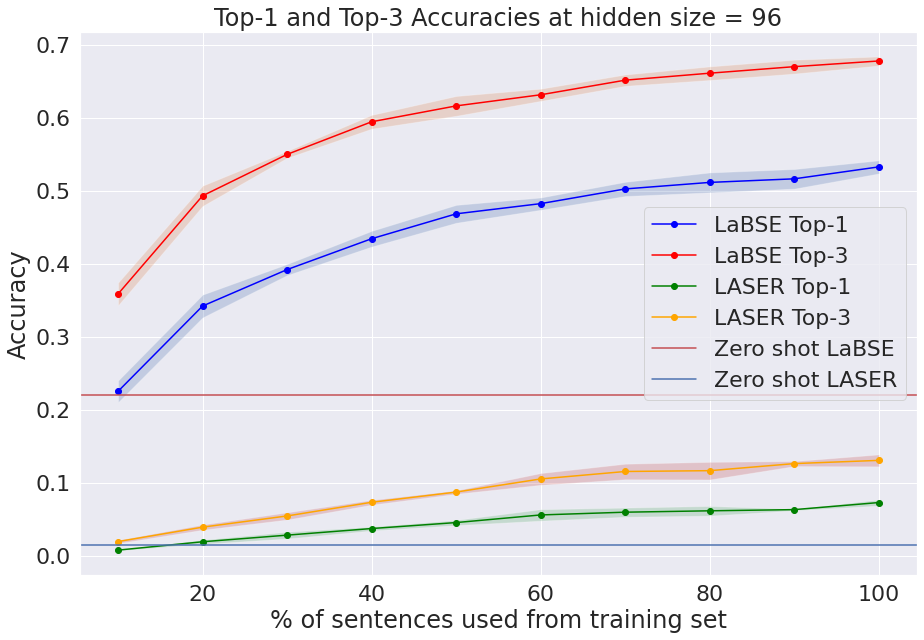

In [ ]:
colors = ['blue','red','green','orange']
perc = [i for i in range(10,110,10)]
files = ['res21.csv','res22.csv','lasres21.csv','lasres22.csv']

for i in range(4):
  res = pd.read_csv(files[i])
  print(res)
  ax2 = plt.plot(perc,res['mean'],marker='o', color=colors[i])
  ra1 = [res['mean'][j]-res['std'][j] for j in range(10)]
  ra2 = [res['mean'][j]+res['std'][j] for j in range(10)]
  ax2 =plt.fill_between(perc, ra1, ra2, alpha=0.25)

ax2 = plt.axhline(y = 0.219945, color = 'r', linestyle = '-')
ax2 = plt.axhline(y = 0.015216, color = 'b', linestyle = '-')
plt.ylabel('Accuracy')
plt.xlabel('% of sentences used from training set')
plt.title('Top-1 and Top-3 Accuracies at hidden size = 96')
plt.legend(['LaBSE Top-1','LaBSE Top-3','LASER Top-1','LASER Top-3','Zero shot LaBSE','Zero shot LASER'],loc=0)

## Overlap

In [ ]:
from functools import reduce
def overlap(files_to_compare):

  dfs = []
  for i in files_to_compare:
    df = pd.read_csv(i)
    try:
      df.drop(['id','sentence1','sentence2'], axis = 1, inplace = True)
    except KeyError:
      pass

    dfs.append(df)

  final_df = reduce(lambda  left,right: pd.merge(left,right,how='inner'), dfs)

  return final_df

In [ ]:
for i in range(1,6):
      train = pd.read_csv('train'+str(i)+'.csv')
      test = pd.read_csv('test'+str(i)+'.csv')

      print(train.head())
      print(test.head())

    

In [ ]:
all = overlap(['train'+str(i)+'.csv' for i in range(2,6)])

In [ ]:
all

In [ ]:
folds2 = finetune_validation(hidden_size=96)

(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1717
13
epoch 50 / 50, step 13/13, loss = 0.2872
20
epoch 50 / 50, step 20/20, loss = 0.0526
26
epoch 50 / 50, step 26/26, loss = 0.2819
32
epoch 50 / 50, step 32/32, loss = 0.3467
39
epoch 50 / 50, step 39/39, loss = 0.1594
45
epoch 50 / 50, step 45/45, loss = 0.3356
51
epoch 50 / 50, step 51/51, loss = 0.3465
58
epoch 50 / 50, step 58/58, loss = 0.2924
64
epoch 50 / 50, step 64/64, loss = 0.3587
(6361, 6) (1591, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1810
13
epoch 50 / 50, step 13/13, loss = 0.3053
20
epoch 50 / 50, step 20/20, loss = 0.0505
26
epoch 50 / 50, step 26/26, loss = 0.2843
32
epoch 50 / 50, step 32/32, loss = 0.3349
39
epoch 50 / 50, step 39/39, loss = 0.1628
45
epoch 50 / 50, step 45/45, loss = 0.3366
51
epoch 50 / 50, step 51/51, loss = 0.3414
58
epoch 50 / 50, step 58/58, loss = 0.2662
64
epoch 50 / 50, step 64/64, loss = 0.3653
(6362, 6) (1590, 6)
7
epoch 50 / 50, step 7/7, loss = 0.1866
13
epoch 50 / 50, step 13

In [5]:
#@title
f0 = {'1': [0.21810182275298554,
  0.3199245757385292,
  0.3997485857950974,
  0.4424890006285355,
  0.47705845380263984,
  0.48585795097423007,
  0.5116279069767442,
  0.5103708359522313,
  0.5166561910747958,
  0.5443117536140792],
 '2': [0.19924575738529227,
  0.3274670018856065,
  0.3689503456945317,
  0.43997485857950974,
  0.4437460716530484,
  0.4726587052168448,
  0.49025769956002513,
  0.5065996228786926,
  0.5015713387806411,
  0.5160276555625393],
 '3': [0.24025157232704403,
  0.3610062893081761,
  0.4018867924528302,
  0.44842767295597485,
  0.48553459119496856,
  0.4861635220125786,
  0.5088050314465409,
  0.5226415094339623,
  0.5270440251572327,
  0.5364779874213836],
 '4': [0.2138364779874214,
  0.3352201257861635,
  0.3905660377358491,
  0.4427672955974843,
  0.45345911949685536,
  0.4710691823899371,
  0.4949685534591195,
  0.5062893081761006,
  0.5150943396226415,
  0.5308176100628931],
 '5': [0.2339622641509434,
  0.3452830188679245,
  0.3867924528301887,
  0.4408805031446541,
  0.46855345911949686,
  0.47044025157232705,
  0.5094339622641509,
  0.5220125786163522,
  0.529559748427673,
  0.5383647798742138]}

In [6]:
#@title
f1 = {'1': [0.3563796354494029,
  0.4833438089252043,
  0.5480829666876178,
  0.6021370207416719,
  0.6266499057196732,
  0.633563796354494,
  0.6543054682589566,
  0.6737900691389064,
  0.6687617850408548,
  0.6807039597737272],
 '2': [0.3312382149591452,
  0.49214330609679446,
  0.5210559396605908,
  0.5927089880578252,
  0.5996228786926462,
  0.6159648020113137,
  0.6455059710873664,
  0.6486486486486487,
  0.6580766813324953,
  0.6781898177247014],
 '3': [0.38113207547169814,
  0.5157232704402516,
  0.5622641509433962,
  0.6062893081761006,
  0.6371069182389937,
  0.6446540880503144,
  0.6660377358490566,
  0.6641509433962264,
  0.6647798742138364,
  0.6893081761006289],
 '4': [0.33647798742138363,
  0.4918238993710692,
  0.5459119496855346,
  0.5930817610062893,
  0.6169811320754717,
  0.630817610062893,
  0.6433962264150943,
  0.6622641509433962,
  0.6691823899371069,
  0.6729559748427673],
 '5': [0.37484276729559746,
  0.5056603773584906,
  0.5515723270440251,
  0.5867924528301887,
  0.6176100628930817,
  0.6352201257861635,
  0.6427672955974842,
  0.6616352201257861,
  0.6773584905660377,
  0.6779874213836478]}

In [16]:
#@title
f2 = {'1': [np.array([-0.25458735, -0.20468007, -0.15477278, -0.1048655 , -0.05495822,
         -0.00505093,  0.04485635,  0.09476364,  0.14467092,  0.1945782 ,
          0.24448549,  0.29439277,  0.34430006,  0.39420734,  0.44411463,
          0.49402191,  0.54392919,  0.59383648,  0.64374376,  0.69365105]),
  np.array([-0.23296535, -0.18455895, -0.13615254, -0.08774613, -0.03933973,
          0.00906668,  0.05747308,  0.10587949,  0.15428589,  0.2026923 ,
          0.2510987 ,  0.29950511,  0.34791151,  0.39631792,  0.44472432,
          0.49313073,  0.54153713,  0.58994354,  0.63834994,  0.68675635]),
  np.array([-0.23821847, -0.18898391, -0.13974936, -0.0905148 , -0.04128024,
          0.00795431,  0.05718887,  0.10642343,  0.15565798,  0.20489254,
          0.2541271 ,  0.30336166,  0.35259621,  0.40183077,  0.45106533,
          0.50029988,  0.54953444,  0.598769  ,  0.64800355,  0.69723811]),
  np.array([-0.23980483, -0.19030947, -0.14081411, -0.09131875, -0.04182339,
          0.00767197,  0.05716733,  0.10666269,  0.15615805,  0.20565341,
          0.25514877,  0.30464413,  0.35413949,  0.40363485,  0.45313022,
          0.50262558,  0.55212094,  0.6016163 ,  0.65111166,  0.70060702]),
  np.array([-0.21386112, -0.16502861, -0.1161961 , -0.06736358, -0.01853107,
          0.03030145,  0.07913396,  0.12796647,  0.17679899,  0.2256315 ,
          0.27446401,  0.32329653,  0.37212904,  0.42096156,  0.46979407,
          0.51862658,  0.5674591 ,  0.61629161,  0.66512412,  0.71395664]),
  np.array([-0.21823671, -0.16819573, -0.11815475, -0.06811376, -0.01807278,
          0.03196821,  0.08200919,  0.13205018,  0.18209116,  0.23213215,
          0.28217313,  0.33221411,  0.3822551 ,  0.43229608,  0.48233707,
          0.53237805,  0.58241904,  0.63246002,  0.68250101,  0.73254199]),
  np.array([-0.24266005, -0.1919579 , -0.14125575, -0.09055361, -0.03985146,
          0.01085068,  0.06155283,  0.11225498,  0.16295712,  0.21365927,
          0.26436142,  0.31506356,  0.36576571,  0.41646785,  0.46717   ,
          0.51787215,  0.56857429,  0.61927644,  0.66997858,  0.72068073]),
  np.array([-0.23065045, -0.17996415, -0.12927785, -0.07859154, -0.02790524,
          0.02278107,  0.07346737,  0.12415367,  0.17483998,  0.22552628,
          0.27621259,  0.32689889,  0.37758519,  0.4282715 ,  0.4789578 ,
          0.52964411,  0.58033041,  0.63101671,  0.68170302,  0.73238932]),
  np.array([-0.22833498, -0.17803658, -0.12773819, -0.0774398 , -0.0271414 ,
          0.02315699,  0.07345538,  0.12375378,  0.17405217,  0.22435056,
          0.27464896,  0.32494735,  0.37524574,  0.42554414,  0.47584253,
          0.52614092,  0.57643932,  0.62673771,  0.6770361 ,  0.7273345 ]),
  np.array([-0.23587149, -0.18453318, -0.13319487, -0.08185656, -0.03051825,
          0.02082007,  0.07215838,  0.12349669,  0.174835  ,  0.22617332,
          0.27751163,  0.32884994,  0.38018825,  0.43152656,  0.48286488,
          0.53420319,  0.5855415 ,  0.63687981,  0.68821813,  0.73955644])],
 '2': [np.array([-0.24932548, -0.2001484 , -0.15097131, -0.10179422, -0.05261713,
         -0.00344004,  0.04573705,  0.09491414,  0.14409123,  0.19326832,
          0.24244541,  0.29162249,  0.34079958,  0.38997667,  0.43915376,
          0.48833085,  0.53750794,  0.58668503,  0.63586212,  0.68503921]),
  np.array([-0.21812269, -0.16973   , -0.1213373 , -0.07294461, -0.02455191,
          0.02384078,  0.07223348,  0.12062617,  0.16901887,  0.21741156,
          0.26580426,  0.31419695,  0.36258964,  0.41098234,  0.45937503,
          0.50776773,  0.55616042,  0.60455312,  0.65294581,  0.70133851]),
  np.array([-0.24037507, -0.18935464, -0.13833421, -0.08731378, -0.03629335,
          0.01472708,  0.06574751,  0.11676794,  0.16778837,  0.2188088 ,
          0.26982923,  0.32084967,  0.3718701 ,  0.42289053,  0.47391096,
          0.52493139,  0.57595182,  0.62697225,  0.67799268,  0.72901311]),
  np.array([-0.17627713, -0.1284463 , -0.08061546, -0.03278462,  0.01504621,
          0.06287705,  0.11070788,  0.15853872,  0.20636955,  0.25420039,
          0.30203123,  0.34986206,  0.3976929 ,  0.44552373,  0.49335457,
          0.5411854 ,  0.58901624,  0.63684708,  0.68467791,  0.73250875]),
  np.array([-0.19228187, -0.14368893, -0.09509598, -0.04650304,  0.0020899 ,
          0.05068285,  0.09927579,  0.14786873,  0.19646168,  0.24505462,
          0.29364756,  0.34224051,  0.39083345,  0.43942639,  0.48801934,
          0.53661228,  0.58520522,  0.63379817,  0.68239111,  0.73098405]),
  np.array([-0.21871334, -0.1691545 , -0.11959565, -0.0700368 , -0.02047796,
          0.02908089,  0.07863974,  0.12819858,  0.17775743,  0.22731628,
          0.27687512,  0.32643397,  0.37599282,  0.42555166,  0.47511051,
          0.52466936,  0.5742282 ,  0.62378705,  0.6733459 ,  0.72290474]),
  np.array([-0.20137531, -0.15145212, -0.10152894, -0.05160576, -0.00168258,
          0.0482406 ,  0.09816378,  0.14808697,  0.19801015,  0.24793333,
          0.29785651,  0.34777969,  0.39770287,  0.44762605,  0.49754924,
          0.54747242,  0.5973956 ,  0.64731878,  0.69724196,  0.74716514]),
  np.array([-0.19380836, -0.14439322, -0.09497808, -0.04556294,  0.00385219,
          0.05326733,  0.10268247,  0.15209761,  0.20151275,  0.25092789,
          0.30034303,  0.34975817,  0.39917331,  0.44858845,  0.49800359,
          0.54741873,  0.59683387,  0.646249  ,  0.69566414,  0.74507928]),
  np.array([-0.20887884, -0.15799729, -0.10711573, -0.05623417, -0.00535261,
          0.04552894,  0.0964105 ,  0.14729206,  0.19817362,  0.24905517,
          0.29993673,  0.35081829,  0.40169985,  0.4525814 ,  0.50346296,
          0.55434452,  0.60522608,  0.65610763,  0.70698919,  0.75787075]),
  np.array([-0.23162262, -0.18014671, -0.12867081, -0.0771949 , -0.02571899,
          0.02575692,  0.07723282,  0.12870873,  0.18018464,  0.23166054,
          0.28313645,  0.33461236,  0.38608827,  0.43756417,  0.48904008,
          0.54051599,  0.5919919 ,  0.6434678 ,  0.69494371,  0.74641962])],
 '3': [np.array([-0.2300626 , -0.18278831, -0.13551402, -0.08823973, -0.04096544,
          0.00630885,  0.05358315,  0.10085744,  0.14813173,  0.19540602,
          0.24268031,  0.2899546 ,  0.33722889,  0.38450319,  0.43177748,
          0.47905177,  0.52632606,  0.57360035,  0.62087464,  0.66814893]),
  np.array([-0.23556052, -0.18767683, -0.13979313, -0.09190944, -0.04402574,
          0.00385795,  0.05174164,  0.09962534,  0.14750903,  0.19539273,
          0.24327642,  0.29116012,  0.33904381,  0.38692751,  0.4348112 ,
          0.48269489,  0.53057859,  0.57846228,  0.62634598,  0.67422967]),
  np.array([-0.22414514, -0.17565899, -0.12717283, -0.07868667, -0.03020051,
          0.01828564,  0.0667718 ,  0.11525796,  0.16374412,  0.21223027,
          0.26071643,  0.30920259,  0.35768875,  0.4061749 ,  0.45466106,
          0.50314722,  0.55163338,  0.60011953,  0.64860569,  0.69709185]),
  np.array([-0.24007623, -0.1893054 , -0.13853457, -0.08776374, -0.03699291,
          0.01377792,  0.06454875,  0.11531958,  0.16609041,  0.21686124,
          0.26763207,  0.3184029 ,  0.36917373,  0.41994456,  0.47071539,
          0.52148622,  0.57225705,  0.62302788,  0.67379871,  0.72456954]),
  np.array([-0.24490668, -0.19398552, -0.14306436, -0.0921432 , -0.04122204,
          0.00969912,  0.06062028,  0.11154144,  0.1624626 ,  0.21338376,
          0.26430492,  0.31522608,  0.36614724,  0.4170684 ,  0.46798956,
          0.51891072,  0.56983188,  0.62075304,  0.6716742 ,  0.72259536]),
  np.array([-0.23347294, -0.18247375, -0.13147455, -0.08047536, -0.02947616,
          0.02152304,  0.07252223,  0.12352143,  0.17452062,  0.22551982,
          0.27651901,  0.32751821,  0.37851741,  0.4295166 ,  0.4805158 ,
          0.53151499,  0.58251419,  0.63351339,  0.68451258,  0.73551178]),
  np.array([-0.26424104, -0.21208484, -0.15992865, -0.10777245, -0.05561626,
         -0.00346006,  0.04869613,  0.10085233,  0.15300853,  0.20516472,
          0.25732092,  0.30947711,  0.36163331,  0.41378951,  0.4659457 ,
          0.5181019 ,  0.57025809,  0.62241429,  0.67457048,  0.72672668]),
  np.array([-0.22935313, -0.17806717, -0.12678121, -0.07549524, -0.02420928,
          0.02707668,  0.07836264,  0.12964861,  0.18093457,  0.23222053,
          0.28350649,  0.33479246,  0.38607842,  0.43736438,  0.48865034,
          0.5399363 ,  0.59122227,  0.64250823,  0.69379419,  0.74508015]),
  np.array([-0.22367658, -0.17239452, -0.12111247, -0.06983041, -0.01854836,
          0.0327337 ,  0.08401575,  0.13529781,  0.18657986,  0.23786191,
          0.28914397,  0.34042602,  0.39170808,  0.44299013,  0.49427219,
          0.54555424,  0.5968363 ,  0.64811835,  0.69940041,  0.75068246]),
  np.array([-0.19520326, -0.1454571 , -0.09571094, -0.04596478,  0.00378138,
          0.05352754,  0.1032737 ,  0.15301986,  0.20276601,  0.25251217,
          0.30225833,  0.35200449,  0.40175065,  0.45149681,  0.50124297,
          0.55098913,  0.60073529,  0.65048145,  0.70022761,  0.74997377])],
 '4': [np.array([-0.22690931, -0.17982155, -0.13273378, -0.08564602, -0.03855825,
          0.00852951,  0.05561728,  0.10270504,  0.14979281,  0.19688057,
          0.24396833,  0.2910561 ,  0.33814386,  0.38523163,  0.43231939,
          0.47940716,  0.52649492,  0.57358269,  0.62067045,  0.66775822]),
  np.array([-0.21520755, -0.16800431, -0.12080107, -0.07359783, -0.02639459,
          0.02080865,  0.06801188,  0.11521512,  0.16241836,  0.2096216 ,
          0.25682484,  0.30402808,  0.35123132,  0.39843455,  0.44563779,
          0.49284103,  0.54004427,  0.58724751,  0.63445075,  0.68165398]),
  np.array([-0.21744525, -0.16863856, -0.11983187, -0.07102518, -0.02221849,
          0.0265882 ,  0.07539489,  0.12420158,  0.17300827,  0.22181496,
          0.27062165,  0.31942834,  0.36823503,  0.41704172,  0.46584841,
          0.5146551 ,  0.56346179,  0.61226848,  0.66107517,  0.70988186]),
  np.array([-0.23061585, -0.18133292, -0.13204999, -0.08276705, -0.03348412,
          0.01579882,  0.06508175,  0.11436468,  0.16364762,  0.21293055,
          0.26221349,  0.31149642,  0.36077935,  0.41006229,  0.45934522,
          0.50862816,  0.55791109,  0.60719402,  0.65647696,  0.70575989]),
  np.array([-0.18239018, -0.13379813, -0.08520607, -0.03661401,  0.01197805,
          0.06057011,  0.10916216,  0.15775422,  0.20634628,  0.25493834,
          0.3035304 ,  0.35212245,  0.40071451,  0.44930657,  0.49789863,
          0.54649069,  0.59508274,  0.6436748 ,  0.69226686,  0.74085892]),
  np.array([-0.15839049, -0.1117771 , -0.0651637 , -0.0185503 ,  0.02806309,
          0.07467649,  0.12128989,  0.16790328,  0.21451668,  0.26113008,
          0.30774347,  0.35435687,  0.40097027,  0.44758366,  0.49419706,
          0.54081046,  0.58742385,  0.63403725,  0.68065065,  0.72726404]),
  np.array([-0.19724284, -0.14694021, -0.09663757, -0.04633494,  0.0039677 ,
          0.05427034,  0.10457297,  0.15487561,  0.20517824,  0.25548088,
          0.30578351,  0.35608615,  0.40638878,  0.45669142,  0.50699405,
          0.55729669,  0.60759932,  0.65790196,  0.7082046 ,  0.75850723]),
  np.array([-0.16139486, -0.11199984, -0.06260481, -0.01320978,  0.03618525,
          0.08558028,  0.13497531,  0.18437034,  0.23376537,  0.2831604 ,
          0.33255543,  0.38195046,  0.43134548,  0.48074051,  0.53013554,
          0.57953057,  0.6289256 ,  0.67832063,  0.72771566,  0.77711069]),
  np.array([-0.19467366, -0.14457549, -0.09447731, -0.04437914,  0.00571903,
          0.0558172 ,  0.10591538,  0.15601355,  0.20611172,  0.25620989,
          0.30630807,  0.35640624,  0.40650441,  0.45660258,  0.50670075,
          0.55679893,  0.6068971 ,  0.65699527,  0.70709344,  0.75719162]),
  np.array([-0.19420192, -0.14393879, -0.09367565, -0.04341252,  0.00685061,
          0.05711374,  0.10737687,  0.15764   ,  0.20790313,  0.25816626,
          0.30842939,  0.35869252,  0.40895565,  0.45921879,  0.50948192,
          0.55974505,  0.61000818,  0.66027131,  0.71053444,  0.76079757])],
 '5': [np.array([-0.22200952, -0.17422615, -0.12644277, -0.07865939, -0.03087602,
          0.01690736,  0.06469074,  0.11247411,  0.16025749,  0.20804087,
          0.25582424,  0.30360762,  0.351391  ,  0.39917438,  0.44695775,
          0.49474113,  0.54252451,  0.59030788,  0.63809126,  0.68587464]),
  np.array([-0.19967359, -0.15149401, -0.10331443, -0.05513484, -0.00695526,
          0.04122433,  0.08940391,  0.13758349,  0.18576308,  0.23394266,
          0.28212225,  0.33030183,  0.37848141,  0.426661  ,  0.47484058,
          0.52302017,  0.57119975,  0.61937933,  0.66755892,  0.7157385 ]),
  np.array([-0.22131148, -0.17240475, -0.12349803, -0.0745913 , -0.02568458,
          0.02322215,  0.07212887,  0.1210356 ,  0.16994232,  0.21884905,
          0.26775577,  0.3166625 ,  0.36556922,  0.41447595,  0.46338267,
          0.5122894 ,  0.56119612,  0.61010285,  0.65900957,  0.7079163 ]),
  np.array([-0.20510277, -0.15632197, -0.10754117, -0.05876037, -0.00997957,
          0.03880123,  0.08758203,  0.13636283,  0.18514363,  0.23392443,
          0.28270523,  0.33148603,  0.38026683,  0.42904763,  0.47782843,
          0.52660923,  0.57539003,  0.62417083,  0.67295163,  0.72173243]),
  np.array([-0.2082033 , -0.15876081, -0.10931831, -0.05987582, -0.01043332,
          0.03900917,  0.08845167,  0.13789416,  0.18733666,  0.23677915,
          0.28622165,  0.33566414,  0.38510664,  0.43454913,  0.48399163,
          0.53343412,  0.58287662,  0.63231911,  0.68176161,  0.7312041 ]),
  np.array([-0.19838405, -0.14932206, -0.10026006, -0.05119807, -0.00213608,
          0.04692591,  0.0959879 ,  0.14504989,  0.19411188,  0.24317387,
          0.29223586,  0.34129785,  0.39035984,  0.43942184,  0.48848383,
          0.53754582,  0.58660781,  0.6356698 ,  0.68473179,  0.73379378]),
  np.array([-0.20962697, -0.16073478, -0.11184258, -0.06295039, -0.0140582 ,
          0.034834  ,  0.08372619,  0.13261839,  0.18151058,  0.23040278,
          0.27929497,  0.32818716,  0.37707936,  0.42597155,  0.47486375,
          0.52375594,  0.57264814,  0.62154033,  0.67043253,  0.71932472]),
  np.array([-0.1850971 , -0.13638791, -0.08767872, -0.03896953,  0.00973965,
          0.05844884,  0.10715803,  0.15586722,  0.20457641,  0.2532856 ,
          0.30199478,  0.35070397,  0.39941316,  0.44812235,  0.49683154,
          0.54554072,  0.59424991,  0.6429591 ,  0.69166829,  0.74037748]),
  np.array([-0.17920411, -0.13035937, -0.08151463, -0.03266988,  0.01617486,
          0.0650196 ,  0.11386434,  0.16270908,  0.21155382,  0.26039856,
          0.3092433 ,  0.35808804,  0.40693278,  0.45577752,  0.50462226,
          0.553467  ,  0.60231174,  0.65115648,  0.70000122,  0.74884596]),
  np.array([-0.18712702, -0.13774423, -0.08836144, -0.03897865,  0.01040414,
          0.05978693,  0.10916972,  0.15855251,  0.2079353 ,  0.25731809,
          0.30670088,  0.35608367,  0.40546646,  0.45484925,  0.50423204,
          0.55361483,  0.60299762,  0.65238041,  0.7017632 ,  0.75114599])]}

In [7]:
#@title
f3 = {'1': [[0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21823899371069183,
   0.21851385390428213,
   0.21878940731399749,
   0.22031746031746033,
   0.22279792746113988,
   0.2347645429362881,
   0.25624496373892025,
   0.3030973451327434,
   0.38524590163934425,
   0.5133689839572193,
   0.5531914893617021],
  [0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.32032724984266836,
   0.32052896725440805,
   0.3213383838383838,
   0.3249839434810533,
   0.3346801346801347,
   0.3559701492537313,
   0.40150801131008484,
   0.465592972181552,
   0.5495495495495496,
   0.7094017094017094],
  [0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.4,
   0.4005037783375315,
   0.4005037783375315,
   0.4017743979721166,
   0.4069319640564827,
   0.41855807743658213,
   0.4369933677229182,
   0.4867337602927722,
   0.5788732394366197,
   0.6638888888888889,
   0.8151260504201681],
  [0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4427672955974843,
   0.4430459408432977,
   0.44297416509136733,
   0.4433902593295383,
   0.4473684210526316,
   0.45755968169761274,
   0.4784828592268417,
   0.5390070921985816,
   0.631233595800525,
   0.732360097323601,
   0.7961783439490446],
  [0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.4776589049716803,
   0.47732997481108314,
   0.47793190416141235,
   0.480610298792117,
   0.48549323017408125,
   0.4976303317535545,
   0.533231474407945,
   0.5816808309726157,
   0.6727785613540197,
   0.782258064516129,
   0.8368794326241135],
  [0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48646947765890497,
   0.48677581863979846,
   0.48677581863979846,
   0.4901462174189447,
   0.4983755685510071,
   0.5195071868583162,
   0.5575853852263701,
   0.6275303643724697,
   0.7364864864864865,
   0.8020477815699659,
   0.8936170212765957],
  [0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5119496855345912,
   0.512271869100063,
   0.5125944584382871,
   0.5145569620253164,
   0.517948717948718,
   0.5312916111850865,
   0.5612094395280236,
   0.6224862888482633,
   0.7154471544715447,
   0.8186528497409327,
   0.8723404255319149],
  [0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5106918238993711,
   0.5113350125944585,
   0.5113350125944585,
   0.5145939086294417,
   0.519639407598197,
   0.5360269360269361,
   0.5653817082388511,
   0.6381322957198443,
   0.7272727272727273,
   0.8398791540785498,
   0.8362068965517241],
  [0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5169811320754717,
   0.5169811320754717,
   0.517632241813602,
   0.5196451204055766,
   0.5263835263835264,
   0.5397039030955586,
   0.5722801788375559,
   0.637043966323667,
   0.7240896358543417,
   0.8385269121813032,
   0.8913043478260869],
  [0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5440251572327044,
   0.5437382001258654,
   0.5440806045340051,
   0.5468354430379747,
   0.5559870550161812,
   0.5652759084791387,
   0.6033820138355112,
   0.6621359223300971,
   0.768025078369906,
   0.8532110091743119,
   0.8679245283018868]],
 '2': [[0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19949653870358716,
   0.20075997466751108,
   0.20335700451904454,
   0.20855978260869565,
   0.22230950510604872,
   0.2533748701973001,
   0.31273408239700373,
   0.4186046511627907,
   0.4107142857142857],
  [0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.32829237555135476,
   0.3293147208121827,
   0.3339818417639429,
   0.3472889498970487,
   0.37519747235387046,
   0.42344244984160506,
   0.4886561954624782,
   0.6381322957198443,
   0.7051282051282052],
  [0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.369880277252678,
   0.37206349206349204,
   0.3786597267404034,
   0.39275766016713093,
   0.42649434571890144,
   0.4782608695652174,
   0.5753968253968254,
   0.7014925373134329,
   0.7777777777777778],
  [0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.44025157232704404,
   0.44037854889589906,
   0.4438058748403576,
   0.45286750164798945,
   0.47046263345195727,
   0.5160472972972973,
   0.5845070422535211,
   0.6869918699186992,
   0.7980295566502463,
   0.85],
  [0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.444794952681388,
   0.4473516273133376,
   0.45230369889682026,
   0.4692467173462336,
   0.49759229534510435,
   0.5678879310344828,
   0.663003663003663,
   0.7755905511811023,
   0.8255813953488372],
  [0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.473551637279597,
   0.4768253968253968,
   0.48028442146089206,
   0.4939189189189189,
   0.5193916349809886,
   0.5865102639296188,
   0.6666666666666666,
   0.7968253968253968,
   0.8769230769230769],
  [0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49056603773584906,
   0.4905422446406053,
   0.49331635900700194,
   0.5003257328990228,
   0.5184926727145848,
   0.5658657829328915,
   0.6430976430976431,
   0.747104247104247,
   0.8177777777777778,
   0.9285714285714286],
  [0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5069182389937107,
   0.5082070707070707,
   0.5105028644175684,
   0.5169050715214565,
   0.5356895356895357,
   0.5737179487179487,
   0.6380638063806381,
   0.7392120075046904,
   0.8382978723404255,
   0.9264705882352942],
  [0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5018867924528302,
   0.5022082018927445,
   0.5057397959183674,
   0.5134426229508197,
   0.5291637385804638,
   0.5726280436607892,
   0.6499416569428238,
   0.7587628865979381,
   0.8622448979591837,
   0.96],
  [0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5163727959697733,
   0.5190114068441065,
   0.525500322788896,
   0.5394021739130435,
   0.5809225957779516,
   0.6511387163561076,
   0.7336683417085427,
   0.8521400778210116,
   0.9333333333333333]],
 '3': [[0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24040276903713026,
   0.24040276903713026,
   0.240705734089477,
   0.24192526915769474,
   0.2450288646568313,
   0.2536912751677852,
   0.2713120830244626,
   0.31800766283524906,
   0.37351190476190477,
   0.45151515151515154,
   0.5961538461538461],
  [0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.36123348017621143,
   0.36123348017621143,
   0.3614609571788413,
   0.3615141955835962,
   0.3635204081632653,
   0.36983606557377047,
   0.38743824982357095,
   0.42771084337349397,
   0.4988038277511962,
   0.6116279069767442,
   0.7150837988826816],
  [0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.40213971050975456,
   0.40213971050975456,
   0.40264650283553877,
   0.40417457305502846,
   0.40964630225080384,
   0.42112299465240643,
   0.4523281596452328,
   0.5004608294930876,
   0.5824175824175825,
   0.7065217391304348,
   0.8428571428571429],
  [0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.4487098804279421,
   0.4487098804279421,
   0.4487098804279421,
   0.44899244332493704,
   0.4506953223767383,
   0.454254638515675,
   0.4684563758389262,
   0.4988644965934898,
   0.5610724925521351,
   0.6618589743589743,
   0.7508417508417509,
   0.8617021276595744],
  [0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48614609571788414,
   0.48860759493670886,
   0.492948717948718,
   0.5036642238507661,
   0.5382899628252789,
   0.6046287367405979,
   0.7023809523809523,
   0.8132530120481928,
   0.8217054263565892],
  [0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.48646947765890497,
   0.48646947765890497,
   0.48646947765890497,
   0.48921319796954316,
   0.4919614147909968,
   0.5129604365620737,
   0.5495356037151703,
   0.6219512195121951,
   0.7301324503311258,
   0.8422818791946308,
   0.9191919191919192],
  [0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5091252359974827,
   0.5091252359974827,
   0.5091252359974827,
   0.510410094637224,
   0.5140664961636828,
   0.523841059602649,
   0.5599415204678363,
   0.6177285318559557,
   0.6839237057220708,
   0.8204419889502762,
   0.8787878787878788],
  [0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5229704216488358,
   0.5229704216488358,
   0.5229704216488358,
   0.5232997481108312,
   0.5244134432466709,
   0.5289948453608248,
   0.5490463215258855,
   0.5940671350507416,
   0.6683937823834197,
   0.75,
   0.8327759197324415,
   0.8876404494382022],
  [0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.527375707992448,
   0.527375707992448,
   0.5280403276622558,
   0.5310913705583756,
   0.5375647668393783,
   0.5607217210270645,
   0.601741884402217,
   0.6924754634678298,
   0.7630662020905923,
   0.8576779026217228,
   0.9518072289156626],
  [0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5368156073001888,
   0.5368156073001888,
   0.5368156073001888,
   0.5372005044136192,
   0.5407643312101911,
   0.547945205479452,
   0.5734168406402227,
   0.616382806163828,
   0.70917225950783,
   0.7954144620811288,
   0.8687943262411347,
   0.9239130434782609]],
 '4': [[0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.21397105097545627,
   0.21451104100946372,
   0.21725239616613418,
   0.22319034852546918,
   0.2418001525553013,
   0.2731707317073171,
   0.32710280373831774,
   0.43666666666666665,
   0.5612244897959183],
  [0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3354310887350535,
   0.3362776025236593,
   0.33951406649616367,
   0.34432717678100266,
   0.36101083032490977,
   0.40641711229946526,
   0.49340369393139843,
   0.5762273901808785,
   0.6620689655172414],
  [0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3908118313404657,
   0.39204545454545453,
   0.39372599231754163,
   0.4088135593220339,
   0.4360730593607306,
   0.49554896142433236,
   0.5764895330112721,
   0.6766666666666666,
   0.8409090909090909],
  [0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4430459408432977,
   0.44388398486759145,
   0.4485623003194888,
   0.45772787318361957,
   0.4782608695652174,
   0.5381165919282511,
   0.6084010840108401,
   0.7017994858611826,
   0.816793893129771],
  [0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.4543163201008192,
   0.45685279187817257,
   0.46705805609915196,
   0.48360083740404747,
   0.5209531635168447,
   0.5979381443298969,
   0.693089430894309,
   0.817351598173516,
   0.9038461538461539],
  [0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.47132955261499687,
   0.47455470737913485,
   0.4846705805609915,
   0.49793672627235214,
   0.5305313243457573,
   0.59536354056902,
   0.7003311258278145,
   0.788961038961039,
   0.8596491228070176],
  [0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.49558638083228246,
   0.4993638676844784,
   0.5081967213114754,
   0.529287226534933,
   0.5817267393126572,
   0.6542617046818727,
   0.7807017543859649,
   0.8571428571428571,
   0.8717948717948718],
  [0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5078963992419456,
   0.5147247119078106,
   0.5281879194630873,
   0.5631578947368421,
   0.6254646840148699,
   0.7302052785923754,
   0.8337950138504155,
   0.916030534351145,
   0.9310344827586207],
  [0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5157629255989912,
   0.5193650793650794,
   0.5252918287937743,
   0.5501051156271899,
   0.5962014863748968,
   0.6771561771561772,
   0.7847082494969819,
   0.8783783783783784,
   0.9814814814814815],
  [0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5318210459987398,
   0.5356234096692112,
   0.542098445595855,
   0.5645161290322581,
   0.6173044925124792,
   0.6980023501762632,
   0.7950819672131147,
   0.8904761904761904,
   0.9473684210526315]],
 '5': [[0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2341095028319698,
   0.2341095028319698,
   0.23436512950094757,
   0.23714652956298202,
   0.2452054794520548,
   0.2716248989490703,
   0.30952380952380953,
   0.3781818181818182,
   0.450199203187251,
   0.5875],
  [0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.34550031466331027,
   0.34615384615384615,
   0.34790874524714827,
   0.3511943189154293,
   0.3704481792717087,
   0.412751677852349,
   0.492379835873388,
   0.6027944111776448,
   0.7155555555555555,
   0.8103448275862069],
  [0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.38727959697733,
   0.3887484197218711,
   0.39208173690932313,
   0.4056603773584906,
   0.43730886850152906,
   0.4935064935064935,
   0.5806451612903226,
   0.7058823529411765,
   0.7863247863247863],
  [0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4417139256458727,
   0.44367088607594934,
   0.44743589743589746,
   0.4648173207036536,
   0.5011727912431587,
   0.5634095634095634,
   0.6601941747572816,
   0.7744107744107744,
   0.8495575221238938],
  [0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46880907372400754,
   0.47114774889029803,
   0.4774193548387097,
   0.4965659340659341,
   0.5329626687847498,
   0.6018808777429467,
   0.6988155668358714,
   0.7925170068027211,
   0.853448275862069],
  [0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.4706994328922495,
   0.4724159797083069,
   0.47935483870967743,
   0.5038062283737024,
   0.5395051875498803,
   0.59958071278826,
   0.6901172529313233,
   0.7908496732026143,
   0.8632478632478633],
  [0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5100755667506297,
   0.5123339658444023,
   0.5166240409207161,
   0.5339153794492948,
   0.5655120481927711,
   0.6281690140845071,
   0.6956521739130435,
   0.8025641025641026,
   0.8620689655172413],
  [0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5217117684078036,
   0.5230283911671925,
   0.5240506329113924,
   0.5300970873786408,
   0.5542501727712509,
   0.6030844155844156,
   0.6571428571428571,
   0.746218487394958,
   0.8382838283828383,
   0.9256198347107438],
  [0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.5308953341740227,
   0.5336294416243654,
   0.5428571428571428,
   0.5619314205738278,
   0.6084089035449299,
   0.6774193548387096,
   0.7676190476190476,
   0.8661710037174721,
   0.9150943396226415],
  [0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5387035871617369,
   0.5397225725094578,
   0.5428027901077996,
   0.5499677627337202,
   0.5717270194986073,
   0.6096169519152405,
   0.6918798665183538,
   0.7826887661141805,
   0.8702290076335878,
   0.9279279279279279]]}

In [8]:
#@title
f4 = {'1': [[0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21810182275298554,
   0.21621621621621623,
   0.213073538654934,
   0.1998742928975487,
   0.17221873035826524,
   0.1181646763042112,
   0.06033940917661848,
   0.016341923318667503],
  [0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3199245757385292,
   0.3180389692017599,
   0.31238214959145194,
   0.2998114393463231,
   0.2677561282212445,
   0.1998742928975487,
   0.11502199874292897,
   0.05216844751728473],
  [0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.3997485857950974,
   0.39849151477058453,
   0.39849151477058453,
   0.3940917661847894,
   0.3727215587680704,
   0.3343808925204274,
   0.2583280955373979,
   0.15021998742928974,
   0.06096794468887492],
  [0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4424890006285355,
   0.4418604651162791,
   0.4406033940917662,
   0.4380892520427404,
   0.4336895034569453,
   0.41231929604022627,
   0.382149591451917,
   0.3023255813953488,
   0.1891891891891892,
   0.0785669390320553],
  [0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.47705845380263984,
   0.4764299182903834,
   0.4764299182903834,
   0.4751728472658705,
   0.4732872407291012,
   0.4619736015084852,
   0.43871778755499685,
   0.3871778755499686,
   0.2998114393463231,
   0.18290383406662478,
   0.07416719044626022],
  [0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.48585795097423007,
   0.4846008799497172,
   0.4820867379006914,
   0.47705845380263984,
   0.44123192960402263,
   0.38969201759899436,
   0.2740414833438089,
   0.147705845380264,
   0.05279698302954117],
  [0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5116279069767442,
   0.5109993714644877,
   0.5078566939032055,
   0.5015713387806411,
   0.4783155248271527,
   0.42803268384663734,
   0.33186675047140163,
   0.19861722187303582,
   0.07730986800754243],
  [0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5103708359522313,
   0.5097423004399748,
   0.507228158390949,
   0.5003142677561282,
   0.470144563167819,
   0.41231929604022627,
   0.3016970458830924,
   0.17473287240729102,
   0.06096794468887492],
  [0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5166561910747958,
   0.5153991200502829,
   0.51414204902577,
   0.5040854808296669,
   0.48271527341294784,
   0.42803268384663734,
   0.3249528598365808,
   0.18604651162790697,
   0.07730986800754243],
  [0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5443117536140792,
   0.5436832181018227,
   0.5430546825895664,
   0.5430546825895664,
   0.5430546825895664,
   0.5399120050282841,
   0.5279698302954117,
   0.49340037712130735,
   0.4286612193588938,
   0.3079824010056568,
   0.17536140791954746,
   0.05782526712759271]],
 '2': [[0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19924575738529227,
   0.19798868636077938,
   0.19296040226272784,
   0.17787554996857322,
   0.15336266499057197,
   0.1049654305468259,
   0.056568196103079824,
   0.014456316781898177],
  [0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3274670018856065,
   0.3262099308610937,
   0.3236957888120679,
   0.3180389692017599,
   0.2985543683218102,
   0.25204274041483343,
   0.1759899434318039,
   0.10307982401005657,
   0.034569453174104335],
  [0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3689503456945317,
   0.3683218101822753,
   0.36580766813324955,
   0.35449402891263354,
   0.33186675047140163,
   0.26964173475801384,
   0.18227529855436833,
   0.08862350722815839,
   0.026398491514770583],
  [0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43997485857950974,
   0.43871778755499685,
   0.4368321810182275,
   0.431803896920176,
   0.4154619736015085,
   0.38403519798868635,
   0.3130106851037084,
   0.21244500314267756,
   0.10182275298554368,
   0.03205531112507857],
  [0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.4437460716530484,
   0.44311753614079197,
   0.4406033940917662,
   0.4380892520427404,
   0.42677561282212445,
   0.38969201759899436,
   0.3312382149591452,
   0.22752985543683218,
   0.12382149591451917,
   0.044626021370207415],
  [0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.4726587052168448,
   0.47203016970458833,
   0.46700188560653677,
   0.4594594594594595,
   0.42928975487115023,
   0.3771213073538655,
   0.2752985543683218,
   0.15776241357636706,
   0.07165304839723445],
  [0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.49025769956002513,
   0.48900062853551224,
   0.4871150219987429,
   0.48271527341294784,
   0.46700188560653677,
   0.42928975487115023,
   0.36015084852294155,
   0.24324324324324326,
   0.11565053425518541,
   0.03268384663733501],
  [0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5065996228786926,
   0.5059710873664363,
   0.5040854808296669,
   0.4996857322438718,
   0.48585795097423007,
   0.4500314267756128,
   0.36455059710873666,
   0.24764299182903834,
   0.12382149591451917,
   0.039597737272155875],
  [0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5015713387806411,
   0.5003142677561282,
   0.4984286612193589,
   0.49214330609679446,
   0.4732872407291012,
   0.4286612193588938,
   0.3500942803268385,
   0.23130106851037083,
   0.10622250157133878,
   0.03016970458830924],
  [0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5160276555625393,
   0.5153991200502829,
   0.5147705845380264,
   0.5116279069767442,
   0.49905719673161536,
   0.46700188560653677,
   0.3953488372093023,
   0.2752985543683218,
   0.1376492771841609,
   0.04399748585795098]],
 '3': [[0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.24025157232704403,
   0.23773584905660378,
   0.23018867924528302,
   0.2088050314465409,
   0.15786163522012578,
   0.09371069182389936,
   0.0389937106918239],
  [0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.3610062893081761,
   0.360377358490566,
   0.3584905660377358,
   0.35471698113207545,
   0.3452830188679245,
   0.31257861635220124,
   0.2622641509433962,
   0.16540880503144653,
   0.08050314465408805],
  [0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4018867924528302,
   0.4006289308176101,
   0.39622641509433965,
   0.3849056603773585,
   0.34150943396226413,
   0.26666666666666666,
   0.16352201257861634,
   0.07421383647798742],
  [0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44842767295597485,
   0.44654088050314467,
   0.4389937106918239,
   0.41446540880503147,
   0.3553459119496855,
   0.259748427672956,
   0.14025157232704402,
   0.0509433962264151],
  [0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48553459119496856,
   0.48364779874213837,
   0.47547169811320755,
   0.45534591194968554,
   0.39433962264150946,
   0.2968553459119497,
   0.16981132075471697,
   0.06666666666666667],
  [0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4861635220125786,
   0.4849056603773585,
   0.4811320754716981,
   0.4729559748427673,
   0.44654088050314467,
   0.3849056603773585,
   0.27735849056603773,
   0.15786163522012578,
   0.057232704402515724],
  [0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5088050314465409,
   0.5056603773584906,
   0.49748427672955975,
   0.4817610062893082,
   0.4207547169811321,
   0.31572327044025156,
   0.18679245283018867,
   0.0729559748427673],
  [0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.5226415094339623,
   0.520125786163522,
   0.5163522012578616,
   0.5069182389937107,
   0.47861635220125787,
   0.4056603773584906,
   0.2849056603773585,
   0.15660377358490565,
   0.04968553459119497],
  [0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5270440251572327,
   0.5264150943396226,
   0.5220125786163522,
   0.5081761006289308,
   0.4779874213836478,
   0.39937106918238996,
   0.27547169811320754,
   0.1440251572327044,
   0.04968553459119497],
  [0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5364779874213836,
   0.5358490566037736,
   0.5339622641509434,
   0.5283018867924528,
   0.5182389937106918,
   0.4779874213836478,
   0.3987421383647799,
   0.28364779874213836,
   0.1540880503144654,
   0.05345911949685535]],
 '4': [[0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.2138364779874214,
   0.20943396226415095,
   0.19937106918238995,
   0.1761006289308176,
   0.1320754716981132,
   0.08238993710691823,
   0.03459119496855346],
  [0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3352201257861635,
   0.3339622641509434,
   0.3283018867924528,
   0.31446540880503143,
   0.28679245283018867,
   0.23522012578616353,
   0.14025157232704402,
   0.06037735849056604],
  [0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3905660377358491,
   0.3867924528301887,
   0.37924528301886795,
   0.360377358490566,
   0.3150943396226415,
   0.22515723270440252,
   0.12767295597484277,
   0.04654088050314465],
  [0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.4427672955974843,
   0.44150943396226416,
   0.4358490566037736,
   0.41509433962264153,
   0.37735849056603776,
   0.28238993710691823,
   0.17169811320754716,
   0.06729559748427673],
  [0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.45345911949685536,
   0.4528301886792453,
   0.45031446540880504,
   0.4358490566037736,
   0.3987421383647799,
   0.3283018867924528,
   0.21446540880503145,
   0.11257861635220126,
   0.029559748427672956],
  [0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.4710691823899371,
   0.47044025157232705,
   0.4691823899371069,
   0.46729559748427674,
   0.45534591194968554,
   0.4207547169811321,
   0.3553459119496855,
   0.2660377358490566,
   0.15283018867924528,
   0.061635220125786164],
  [0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.4949685534591195,
   0.49433962264150944,
   0.4937106918238994,
   0.48742138364779874,
   0.4716981132075472,
   0.43647798742138366,
   0.34276729559748426,
   0.2238993710691824,
   0.09811320754716982,
   0.021383647798742137],
  [0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5062893081761006,
   0.5056603773584906,
   0.5056603773584906,
   0.4949685534591195,
   0.4710691823899371,
   0.42327044025157234,
   0.3132075471698113,
   0.18930817610062894,
   0.07547169811320754,
   0.016981132075471698],
  [0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5150943396226415,
   0.5144654088050314,
   0.5144654088050314,
   0.5094339622641509,
   0.4937106918238994,
   0.4540880503144654,
   0.3654088050314465,
   0.24528301886792453,
   0.12264150943396226,
   0.03333333333333333],
  [0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.5308176100628931,
   0.529559748427673,
   0.5264150943396226,
   0.5062893081761006,
   0.4666666666666667,
   0.37358490566037733,
   0.2440251572327044,
   0.11761006289308176,
   0.033962264150943396]],
 '5': [[0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.2339622641509434,
   0.23333333333333334,
   0.2320754716981132,
   0.22515723270440252,
   0.21132075471698114,
   0.17987421383647798,
   0.13081761006289308,
   0.0710691823899371,
   0.029559748427672956],
  [0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3452830188679245,
   0.3421383647798742,
   0.33270440251572325,
   0.30943396226415093,
   0.2641509433962264,
   0.189937106918239,
   0.10125786163522013,
   0.029559748427672956],
  [0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.3867924528301887,
   0.38616352201257864,
   0.3786163522012579,
   0.35974842767295595,
   0.31069182389937106,
   0.23773584905660378,
   0.14339622641509434,
   0.05786163522012579],
  [0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4408805031446541,
   0.4389937106918239,
   0.4320754716981132,
   0.40314465408805034,
   0.34088050314465407,
   0.25660377358490566,
   0.14465408805031446,
   0.06037735849056604],
  [0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.46855345911949686,
   0.4679245283018868,
   0.46729559748427674,
   0.46540880503144655,
   0.4547169811320755,
   0.4220125786163522,
   0.3622641509433962,
   0.259748427672956,
   0.14654088050314465,
   0.062264150943396226],
  [0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.47044025157232705,
   0.469811320754717,
   0.46855345911949686,
   0.46729559748427674,
   0.4578616352201258,
   0.42515723270440253,
   0.35974842767295595,
   0.2591194968553459,
   0.15220125786163521,
   0.06352201257861635],
  [0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5094339622641509,
   0.5081761006289308,
   0.5,
   0.47232704402515724,
   0.4207547169811321,
   0.3119496855345912,
   0.1968553459119497,
   0.09433962264150944],
  [0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5220125786163522,
   0.5213836477987421,
   0.5213836477987421,
   0.5207547169811321,
   0.5150943396226415,
   0.5044025157232704,
   0.46729559748427674,
   0.3905660377358491,
   0.2792452830188679,
   0.15974842767295597,
   0.07044025157232704],
  [0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.529559748427673,
   0.5289308176100629,
   0.5257861635220126,
   0.5050314465408805,
   0.4641509433962264,
   0.38301886792452833,
   0.25345911949685535,
   0.14654088050314465,
   0.0610062893081761],
  [0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5383647798742138,
   0.5364779874213836,
   0.5163522012578616,
   0.47044025157232705,
   0.39119496855345914,
   0.2672955974842767,
   0.14339622641509434,
   0.06477987421383648]]}

In [17]:
folds2 = (f0, f1, f2, f3, f4)

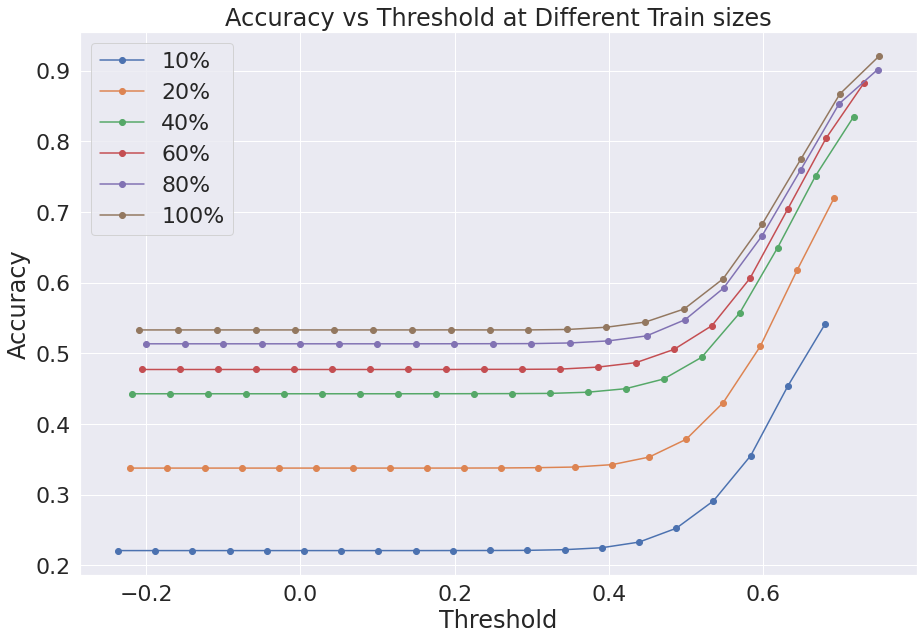

In [18]:
avg_t = [pd.DataFrame([folds2[2][str(i)][j] for i in range(1,6)]).mean(axis=0) for j in range(10)]

avg_a = [pd.DataFrame([folds2[3][str(i)][j] for i in range(1,6)]).mean(axis=0) for j in range(10)]
std_a = [pd.DataFrame([folds2[3][str(i)][j] for i in range(1,6)]).std(axis=0) for j in range(10)]

rs = [0,1,3,5,7,9]
for i in rs:
  ax2 = plt.plot(avg_t[i],avg_a[i],marker='o')

  ra1 = [avg_a[i][j]-std_a[i][j] for j in range(10)]
  ra2 = [avg_a[i][j]+std_a[i][j] for j in range(10)]
  #ax2 =plt.fill_between(avg_t[i], ra1, ra2, alpha=0.25)

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.title('Accuracy vs Threshold at Different Train sizes')
plt.legend([str(i)+'%' for i in [10,20,40,60,80,100]],loc=2)

In [19]:
avg_p = [pd.DataFrame([folds2[3][str(i)][j] for i in range(1,6)]).mean(axis=0) for j in range(10)]
std_p = [pd.DataFrame([folds2[3][str(i)][j] for i in range(1,6)]).std(axis=0) for j in range(10)]

print(avg_p)
print(std_p)

[0     0.221080
1     0.221080
2     0.221080
3     0.221080
4     0.221080
5     0.221080
6     0.221080
7     0.221080
8     0.221080
9     0.221137
10    0.221222
11    0.221414
12    0.222376
13    0.225117
14    0.233082
15    0.252658
16    0.291435
17    0.355355
18    0.454071
19    0.541757
dtype: float64, 0     0.337780
1     0.337780
2     0.337780
3     0.337780
4     0.337780
5     0.337780
6     0.337780
7     0.337780
8     0.337780
9     0.337826
10    0.337950
11    0.338373
12    0.339271
13    0.342639
14    0.353316
15    0.378474
16    0.430292
17    0.509850
18    0.618219
19    0.720406
dtype: float64, 0     0.389589
1     0.389589
2     0.389589
3     0.389589
4     0.389589
5     0.389589
6     0.389589
7     0.389589
8     0.389589
9     0.389690
10    0.389790
11    0.390224
12    0.391761
13    0.396209
14    0.409383
15    0.437840
16    0.490902
17    0.578764
18    0.690890
19    0.812599
dtype: float64, 0     0.442908
1     0.442908
2     0.442908
3     

In [20]:
avg_r = [pd.DataFrame([folds2[4][str(i)][j] for i in range(1,6)]).mean(axis=0) for j in range(10)]
std_r = [pd.DataFrame([folds2[4][str(i)][j] for i in range(1,6)]).std(axis=0) for j in range(10)]

print(avg_r)
print(std_r)

[0     0.221080
1     0.221080
2     0.221080
3     0.221080
4     0.221080
5     0.221080
6     0.221080
7     0.221080
8     0.221080
9     0.221080
10    0.221080
11    0.221080
12    0.220954
13    0.220074
14    0.215672
15    0.203726
16    0.178072
17    0.128777
18    0.072815
19    0.026789
dtype: float64, 0     0.337780
1     0.337780
2     0.337780
3     0.337780
4     0.337780
5     0.337780
6     0.337780
7     0.337780
8     0.337780
9     0.337780
10    0.337780
11    0.337780
12    0.337403
13    0.335265
14    0.329229
15    0.313510
16    0.276664
17    0.212657
18    0.125004
19    0.051436
dtype: float64, 0     0.389589
1     0.389589
2     0.389589
3     0.389589
4     0.389589
5     0.389589
6     0.389589
7     0.389589
8     0.389589
9     0.389589
10    0.389589
11    0.389589
12    0.389212
13    0.387577
14    0.380535
15    0.361924
16    0.314264
17    0.234033
18    0.134687
19    0.053197
dtype: float64, 0     0.442908
1     0.442908
2     0.442908
3     

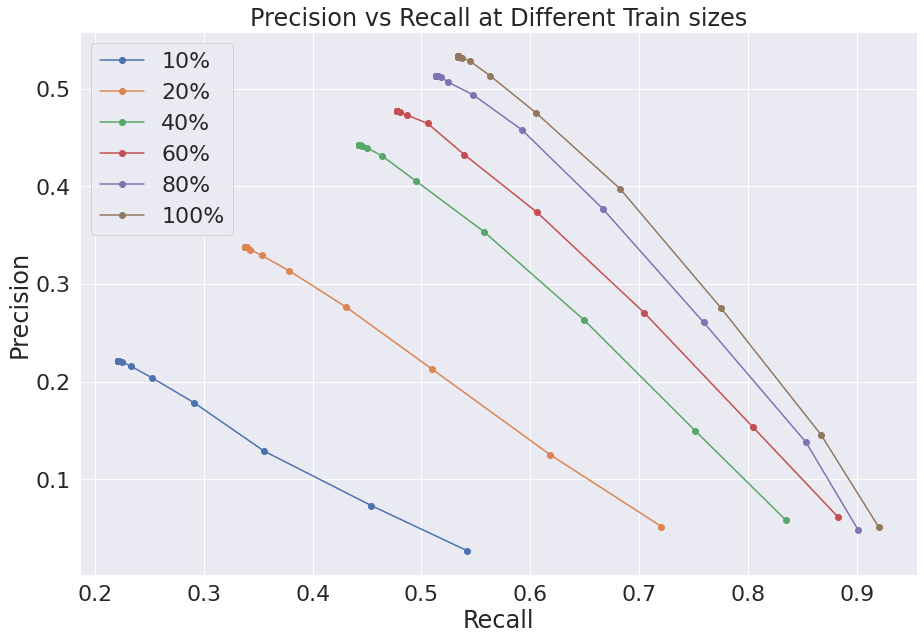

In [21]:
rs = [0,1,3,5,7,9]
for i in rs:
  ax2 = plt.plot(avg_p[i],avg_r[i],marker='o')

  # ra1 = [avg_a[i][j]-std_a[i][j] for j in range(10)]
  # ra2 = [avg_a[i][j]+std_a[i][j] for j in range(10)]
  #ax2 =plt.fill_between(avg_t[i], ra1, ra2, alpha=0.25)

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs Recall at Different Train sizes')
plt.legend([str(i)+'%' for i in [10,20,40,60,80,100]],loc=2)

In [29]:
rs = [0,1,3,5,7,9]
for i in rs:
  print('At train size:', 10*(i+1))
  print('===============================================')
  for x, y, z in zip(avg_t[i], avg_p[i],avg_r[i]):
    t = round(x,2)
    p = round(y,2)
    r = round(z,2)
    f_1 = round((2*p*r)/(p+r),2)
    res = "Threshold : {} Precision : {} Recall : {} F1: {}".format(t,p ,r , f_1)
    print(res)

At train size: 10
Threshold : -0.24 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : -0.19 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : -0.14 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : -0.09 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : -0.04 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.0 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.05 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.1 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.15 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.2 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.25 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.29 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.34 Precision : 0.22 Recall : 0.22 F1: 0.22
Threshold : 0.39 Precision : 0.23 Recall : 0.22 F1: 0.22
Threshold : 0.44 Precision : 0.23 Recall : 0.22 F1: 0.22
Threshold : 0.49 Precision : 0.25 Recall : 0.2 F1: 0.22
Threshold : 0.54 Precision : 0.29 Recall : 0.18 F1: 0.22
Threshold : 